In [193]:
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import numpy as np

In [194]:
loan_data = pd.read_csv(r'D:\Datasets\LendingClub\loan_data_processed.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_4628\1477770770.py:1: DtypeWarning: Columns (21,49) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data = pd.read_csv(r'D:\Datasets\LendingClub\loan_data_processed.csv')


In [195]:
# default definition:
# 90 days + overdue
# fraud committed
# 0 defaulted loan
# 1 good loan

# logistic regression
# ln(odds) of an outcome logarithm of the ratio of (non-defaults/default) dependent variable
# independent variables are linear combination of categorical/dummy variables
# turn continuous variables into categories and dummy variables

# PD model

## Data preparation

### Dependent variable. Good/Bad(default) definition. Default and Non-default accounts

In [196]:
loan_data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [197]:
loan_data['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [198]:
loan_data['loan_status'].value_counts() / len(loan_data)

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

In [199]:
# positive coefficients = more creditworthiness
# negative coefficients = less creditworthiness

# np.where(condition, value if true, value if false)
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin(['Charged Off',
                                                               'Defeault',
                                                               'Does not meet the credit policy. Status:Charged Off',
                                                               'Late (31-120 days)']), 0, 1)

In [200]:
loan_data['good_bad'].describe()

count    466285.000000
mean          0.892478
std           0.309776
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: good_bad, dtype: float64

### Constructing categorical variables from continuous variables using weight of evidence, fine classing and coarse classing

In [201]:
# discrete variables are just converted into dummy variables
# weight of evidence (to what extent an independent variable will predict a dependent variable) to
# determine cutoffs for classing of continuous variables
#
# WoEi = ln(%(y=1)i / %(y=0)i)
#      = ln(%good/%bad)
#
# if Higher education and no higher education
# WoE(higher) = ln( [good_higher/total_good] / [bad_higher/total_bad] )
# WoE(no higher) = ln( [good_no_higher/total_good] / [bad_no_higher/total_bad])
#
# the further away from 0 the better the category is in differentiating between two outcomes

# fine classing is identical cutoff band widths
# coarse classing is creating new categories based on initial ones and to create bigger categories with similar weight of evidence

# Information value of the original independent var with respect to the dependent var (0 - 1)
# (weighted average of the weights of evidence of the k categories)
# sigma [(%good - %bad) x ln(%good/%bad)]

# IV <0.02 = no predictive power
# 0.02 < IV < 0.1 = weak predictive power
# 0.1 < IV < 0.3 = medium predictive power
# 0.3 < IV < 0.5 = strong predictive power
# 0.5 < IV = suspiciously high, too good to be true

In [202]:
# overfitting
# underfitting

In [203]:
from sklearn.model_selection import train_test_split

In [204]:
loan_data_inputs_train, loan_data_inputs_test, loan_data_targets_train, loan_data_targets_test = train_test_split(loan_data.drop('good_bad', axis=1), loan_data['good_bad'], test_size=0.2, random_state=1)

In [205]:
loan_data_inputs_train.shape

(373028, 208)

In [206]:
loan_data_targets_train.shape

(373028,)

In [207]:
loan_data_inputs_test.shape

(93257, 208)

In [208]:
loan_data_targets_test.shape

(93257,)

### Data preparation

In [345]:
# the below are uncommented to run the processing through the test data
#df_inputs_prepr = loan_data_inputs_train
#df_targets_prepr = loan_data_targets_train
df_inputs_prepr = loan_data_inputs_test
df_targets_prepr = loan_data_targets_test

In [346]:
df_inputs_prepr['grade'].unique()

array(['B', 'D', 'E', 'C', 'F', 'A', 'G'], dtype=object)

In [347]:
df1 = pd.concat([df_inputs_prepr['grade'], df_targets_prepr], axis=1)

In [348]:
df1.head()

grade  good_bad
421662     B         1
345847     D         1
87245      E         1
422411     C         1
131614     F         1

In [349]:
df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].count()

grade  good_bad
0     A     14905
1     B     27347
2     C     25038
3     D     15498
4     E      7155
5     F      2648
6     G       666

In [350]:
df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()

grade  good_bad
0     A  0.959946
1     B  0.923648
2     C  0.888050
3     D  0.846754
4     E  0.805730
5     F  0.746979
6     G  0.728228

In [351]:
df1 = pd.concat([df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].count(),
                df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()], axis=1)

In [352]:
df1

grade  good_bad grade  good_bad
0     A     14905     A  0.959946
1     B     27347     B  0.923648
2     C     25038     C  0.888050
3     D     15498     D  0.846754
4     E      7155     E  0.805730
5     F      2648     F  0.746979
6     G       666     G  0.728228

In [353]:
df1 = df1.iloc[:, [0, 1, 3]]
df1

grade  good_bad  good_bad
0     A     14905  0.959946
1     B     27347  0.923648
2     C     25038  0.888050
3     D     15498  0.846754
4     E      7155  0.805730
5     F      2648  0.746979
6     G       666  0.728228

In [354]:
df1.columns = [df1.columns.values[0], 'n_obs', 'prop_good']
df1

grade  n_obs  prop_good
0     A  14905   0.959946
1     B  27347   0.923648
2     C  25038   0.888050
3     D  15498   0.846754
4     E   7155   0.805730
5     F   2648   0.746979
6     G    666   0.728228

In [355]:
df1['prop_n_obs'] = df1['n_obs'] / df1['n_obs'].sum()
df1

grade  n_obs  prop_good  prop_n_obs
0     A  14905   0.959946    0.159827
1     B  27347   0.923648    0.293243
2     C  25038   0.888050    0.268484
3     D  15498   0.846754    0.166186
4     E   7155   0.805730    0.076723
5     F   2648   0.746979    0.028395
6     G    666   0.728228    0.007142

In [356]:
df1['n_good'] = df1['prop_good'] * df1['n_obs']
df1['n_bad'] = (1 - df1['prop_good']) * df1['n_obs']
df1

grade  n_obs  prop_good  prop_n_obs   n_good   n_bad
0     A  14905   0.959946    0.159827  14308.0   597.0
1     B  27347   0.923648    0.293243  25259.0  2088.0
2     C  25038   0.888050    0.268484  22235.0  2803.0
3     D  15498   0.846754    0.166186  13123.0  2375.0
4     E   7155   0.805730    0.076723   5765.0  1390.0
5     F   2648   0.746979    0.028395   1978.0   670.0
6     G    666   0.728228    0.007142    485.0   181.0

In [357]:
df1['prop_n_good'] = df1['n_good'] / df1['n_good'].sum()
df1['prop_n_bad'] = df1['n_bad'] / df1['n_bad'].sum()
df1

grade  n_obs  prop_good  prop_n_obs   n_good   n_bad  prop_n_good  \
0     A  14905   0.959946    0.159827  14308.0   597.0     0.172068   
1     B  27347   0.923648    0.293243  25259.0  2088.0     0.303765   
2     C  25038   0.888050    0.268484  22235.0  2803.0     0.267399   
3     D  15498   0.846754    0.166186  13123.0  2375.0     0.157818   
4     E   7155   0.805730    0.076723   5765.0  1390.0     0.069330   
5     F   2648   0.746979    0.028395   1978.0   670.0     0.023787   
6     G    666   0.728228    0.007142    485.0   181.0     0.005833   

   prop_n_bad  
0    0.059086  
1    0.206651  
2    0.277415  
3    0.235055  
4    0.137569  
5    0.066310  
6    0.017914

In [358]:
df1['WoE'] = np.log(df1['prop_n_good'] / df1['prop_n_bad'])
df1

grade  n_obs  prop_good  prop_n_obs   n_good   n_bad  prop_n_good  \
0     A  14905   0.959946    0.159827  14308.0   597.0     0.172068   
1     B  27347   0.923648    0.293243  25259.0  2088.0     0.303765   
2     C  25038   0.888050    0.268484  22235.0  2803.0     0.267399   
3     D  15498   0.846754    0.166186  13123.0  2375.0     0.157818   
4     E   7155   0.805730    0.076723   5765.0  1390.0     0.069330   
5     F   2648   0.746979    0.028395   1978.0   670.0     0.023787   
6     G    666   0.728228    0.007142    485.0   181.0     0.005833   

   prop_n_bad       WoE  
0    0.059086  1.068906  
1    0.206651  0.385225  
2    0.277415 -0.036774  
3    0.235055 -0.398382  
4    0.137569 -0.685249  
5    0.066310 -1.025187  
6    0.017914 -1.122099

In [359]:
df1 = df1.sort_values(['WoE'])
df1 = df1.reset_index(drop = True)
df1

grade  n_obs  prop_good  prop_n_obs   n_good   n_bad  prop_n_good  \
0     G    666   0.728228    0.007142    485.0   181.0     0.005833   
1     F   2648   0.746979    0.028395   1978.0   670.0     0.023787   
2     E   7155   0.805730    0.076723   5765.0  1390.0     0.069330   
3     D  15498   0.846754    0.166186  13123.0  2375.0     0.157818   
4     C  25038   0.888050    0.268484  22235.0  2803.0     0.267399   
5     B  27347   0.923648    0.293243  25259.0  2088.0     0.303765   
6     A  14905   0.959946    0.159827  14308.0   597.0     0.172068   

   prop_n_bad       WoE  
0    0.017914 -1.122099  
1    0.066310 -1.025187  
2    0.137569 -0.685249  
3    0.235055 -0.398382  
4    0.277415 -0.036774  
5    0.206651  0.385225  
6    0.059086  1.068906

In [360]:
df1['diff_prop_good'] = df1['prop_good'].diff().abs()
df1['diff_WoE'] = df1['WoE'].diff().abs()
df1

grade  n_obs  prop_good  prop_n_obs   n_good   n_bad  prop_n_good  \
0     G    666   0.728228    0.007142    485.0   181.0     0.005833   
1     F   2648   0.746979    0.028395   1978.0   670.0     0.023787   
2     E   7155   0.805730    0.076723   5765.0  1390.0     0.069330   
3     D  15498   0.846754    0.166186  13123.0  2375.0     0.157818   
4     C  25038   0.888050    0.268484  22235.0  2803.0     0.267399   
5     B  27347   0.923648    0.293243  25259.0  2088.0     0.303765   
6     A  14905   0.959946    0.159827  14308.0   597.0     0.172068   

   prop_n_bad       WoE  diff_prop_good  diff_WoE  
0    0.017914 -1.122099             NaN       NaN  
1    0.066310 -1.025187        0.018751  0.096912  
2    0.137569 -0.685249        0.058751  0.339938  
3    0.235055 -0.398382        0.041024  0.286868  
4    0.277415 -0.036774        0.041296  0.361608  
5    0.206651  0.385225        0.035598  0.421999  
6    0.059086  1.068906        0.036298  0.683681

In [361]:
df1['IV'] = (df1['prop_n_good'] - df1['prop_n_bad']) * df1['WoE']
df1['IV'] = df1['IV'].sum()
df1

grade  n_obs  prop_good  prop_n_obs   n_good   n_bad  prop_n_good  \
0     G    666   0.728228    0.007142    485.0   181.0     0.005833   
1     F   2648   0.746979    0.028395   1978.0   670.0     0.023787   
2     E   7155   0.805730    0.076723   5765.0  1390.0     0.069330   
3     D  15498   0.846754    0.166186  13123.0  2375.0     0.157818   
4     C  25038   0.888050    0.268484  22235.0  2803.0     0.267399   
5     B  27347   0.923648    0.293243  25259.0  2088.0     0.303765   
6     A  14905   0.959946    0.159827  14308.0   597.0     0.172068   

   prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  
0    0.017914 -1.122099             NaN       NaN  0.293229  
1    0.066310 -1.025187        0.018751  0.096912  0.293229  
2    0.137569 -0.685249        0.058751  0.339938  0.293229  
3    0.235055 -0.398382        0.041024  0.286868  0.293229  
4    0.277415 -0.036774        0.041296  0.361608  0.293229  
5    0.206651  0.385225        0.035598  0.421999  0.293229  
6    0.059086  1.068906        0.036298  0.683681  0.293229

### Preprocessing discrete variables: Automating calculations

In [362]:
def woe_discrete(df, discrete_variable_name, good_bad_variable_df):
    
    df = pd.concat([df[discrete_variable_name], good_bad_variable_df], axis=1)
    
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis=1)
    
    df = df.iloc[:, [0, 1, 3]]
    
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    
    return df

In [363]:
df_temp = woe_discrete(df_inputs_prepr, 'grade', df_targets_prepr)
df_temp

grade  n_obs  prop_good  prop_n_obs   n_good   n_bad  prop_n_good  \
0     G    666   0.728228    0.007142    485.0   181.0     0.005833   
1     F   2648   0.746979    0.028395   1978.0   670.0     0.023787   
2     E   7155   0.805730    0.076723   5765.0  1390.0     0.069330   
3     D  15498   0.846754    0.166186  13123.0  2375.0     0.157818   
4     C  25038   0.888050    0.268484  22235.0  2803.0     0.267399   
5     B  27347   0.923648    0.293243  25259.0  2088.0     0.303765   
6     A  14905   0.959946    0.159827  14308.0   597.0     0.172068   

   prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  
0    0.017914 -1.122099             NaN       NaN  0.293229  
1    0.066310 -1.025187        0.018751  0.096912  0.293229  
2    0.137569 -0.685249        0.058751  0.339938  0.293229  
3    0.235055 -0.398382        0.041024  0.286868  0.293229  
4    0.277415 -0.036774        0.041296  0.361608  0.293229  
5    0.206651  0.385225        0.035598  0.421999  0.293229  
6    0.059086  1.068906        0.036298  0.683681  0.293229

### Preprocessing discrete variables: Visualising results

In [364]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set

<function seaborn.rcmod.set(*args, **kwargs)>

In [365]:
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[: , 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize = (18, 6)) # width/height
    plt.plot(x, y, marker='o', linestyle = '--', color= 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

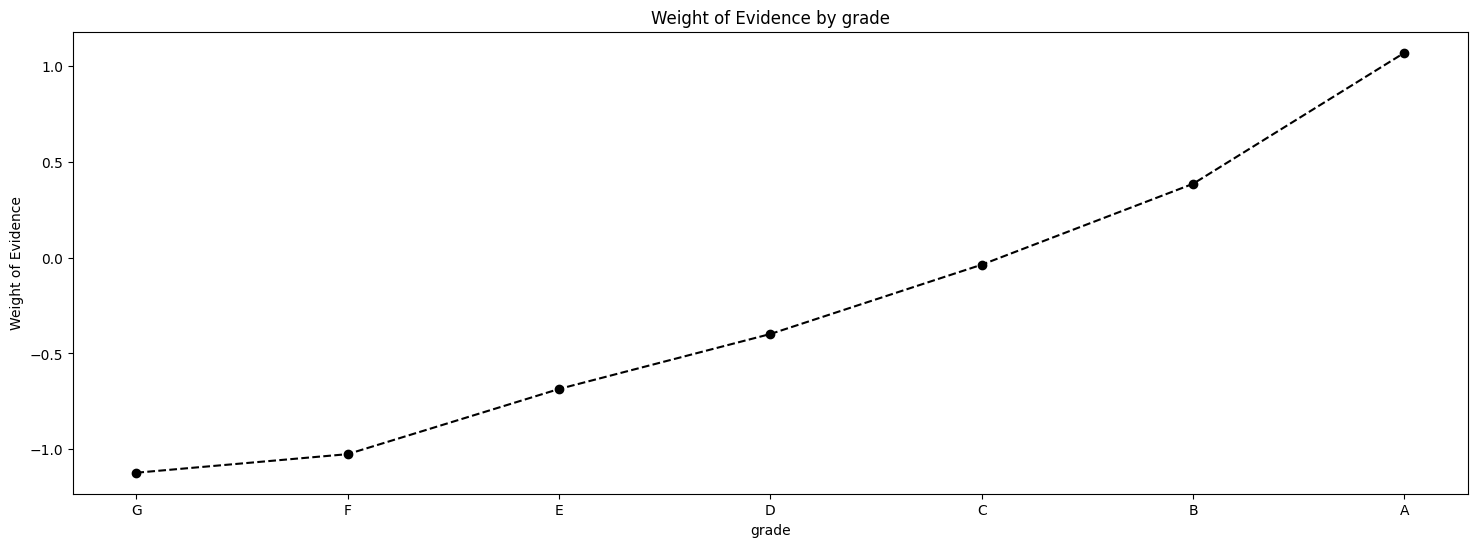

In [366]:
plot_by_woe(df_temp, rotation_of_x_axis_labels = 0)

### Preprocessing discrete Variables: Creating dummy variables, Part 1

In [367]:
df_temp = woe_discrete(df_inputs_prepr, 'home_ownership', df_targets_prepr)
df_temp

home_ownership  n_obs  prop_good  prop_n_obs   n_good   n_bad  prop_n_good  \
0           NONE     10   0.700000    0.000107      7.0     3.0     0.000084   
1          OTHER     37   0.756757    0.000397     28.0     9.0     0.000337   
2           RENT  37746   0.875219    0.404752  33036.0  4710.0     0.397292   
3            OWN   8182   0.894891    0.087736   7322.0   860.0     0.088055   
4       MORTGAGE  47282   0.904361    0.507008  42760.0  4522.0     0.514233   

   prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  
0    0.000297 -1.260453             NaN       NaN  0.021176  
1    0.000891 -0.972771        0.056757  0.287682  0.021176  
2    0.466152 -0.159841        0.118462  0.812930  0.021176  
3    0.085115  0.033956        0.019673  0.193796  0.021176  
4    0.447546  0.138898        0.009470  0.104942  0.021176

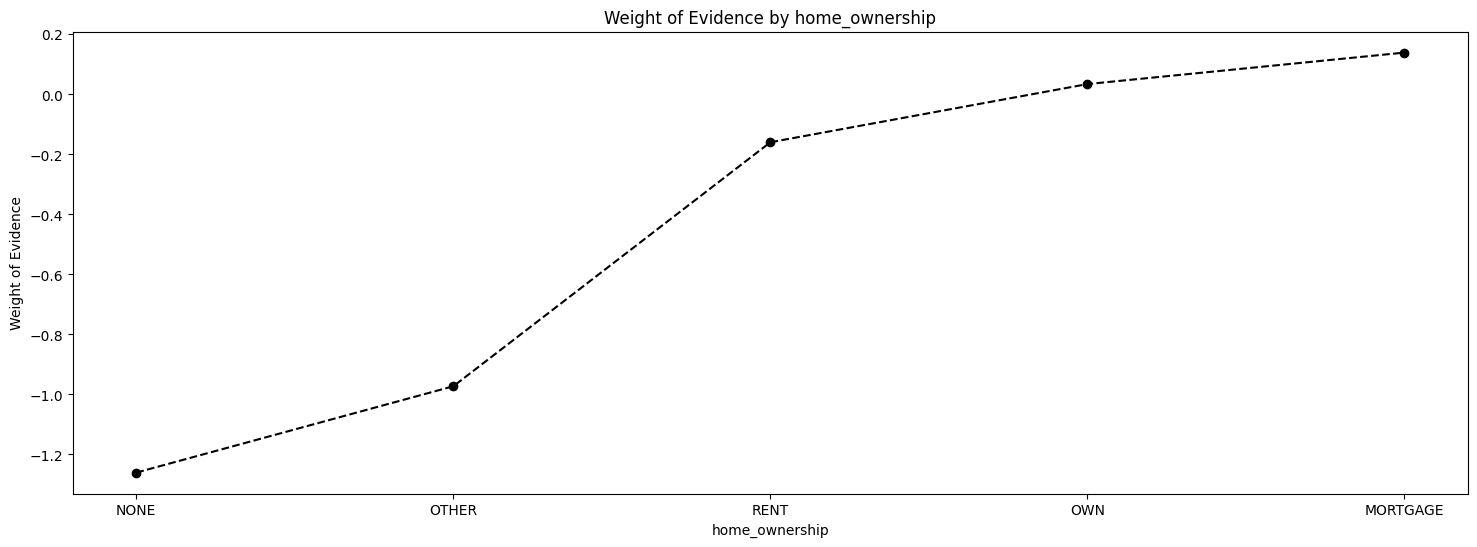

In [368]:
plot_by_woe(df_temp)

In [369]:
# OTHER, NONE and ANY have very little observations, so should not create dummies for these variables
# but we can combine these underrepresented categories into a new category together with the RENT variable
# OWN and MORTGAGE will be seperate dummy variables
df_inputs_prepr['home_ownership:RENT_OTHER_NONE_ANY'] = sum([df_inputs_prepr['home_ownership:RENT'], df_inputs_prepr['home_ownership:OTHER'],
                                                            df_inputs_prepr['home_ownership:NONE'], df_inputs_prepr['home_ownership:ANY']])

### Preprocessing discrete Variables: Creating dummy variables, Part 2

In [370]:
df_inputs_prepr['addr_state'].unique()

array(['OR', 'NY', 'NC', 'CA', 'OH', 'VA', 'MI', 'AZ', 'PA', 'MA', 'NV',
       'FL', 'NJ', 'GA', 'OK', 'IL', 'TX', 'WA', 'AL', 'DC', 'CO', 'MO',
       'SC', 'MD', 'HI', 'LA', 'AK', 'MN', 'TN', 'IN', 'WI', 'CT', 'WY',
       'NM', 'MS', 'KS', 'AR', 'RI', 'UT', 'NH', 'KY', 'MT', 'WV', 'VT',
       'SD', 'DE', 'ID', 'NE', 'IA', 'ME'], dtype=object)

In [371]:
df_temp = woe_discrete(df_inputs_prepr, 'addr_state', df_targets_prepr)
df_temp

addr_state  n_obs  prop_good  prop_n_obs   n_good   n_bad  prop_n_good  \
0          NV   1250   0.855200    0.013404   1069.0   181.0     0.012856   
1          AL   1168   0.873288    0.012525   1020.0   148.0     0.012267   
2          FL   6380   0.874922    0.068413   5582.0   798.0     0.067129   
3          DE    256   0.878906    0.002745    225.0    31.0     0.002706   
4          MO   1490   0.879866    0.015977   1311.0   179.0     0.015766   
5          NY   8025   0.880872    0.086053   7069.0   956.0     0.085012   
6          UT    714   0.880952    0.007656    629.0    85.0     0.007564   
7          KY    844   0.882701    0.009050    745.0    99.0     0.008959   
8          MA   2230   0.883408    0.023912   1970.0   260.0     0.023691   
9          LA   1044   0.884100    0.011195    923.0   121.0     0.011100   
10         AR    696   0.885057    0.007463    616.0    80.0     0.007408   
11         MI   2315   0.885961    0.024824   2051.0   264.0     0.024665   
12         MD   2215   0.886230    0.023752   1963.0   252.0     0.023607   
13         PA   3263   0.888140    0.034989   2898.0   365.0     0.034851   
14         AZ   2156   0.888683    0.023119   1916.0   240.0     0.023042   
15         CA  14352   0.889423    0.153897  12765.0  1587.0     0.153512   
16         NJ   3614   0.889873    0.038753   3216.0   398.0     0.038676   
17         OK    805   0.891925    0.008632    718.0    87.0     0.008635   
18         NM    539   0.892393    0.005780    481.0    58.0     0.005785   
19         MN   1661   0.893438    0.017811   1484.0   177.0     0.017847   
20         NC   2510   0.894024    0.026915   2244.0   266.0     0.026986   
21         OH   3086   0.894362    0.033091   2760.0   326.0     0.033192   
22         VA   2873   0.894883    0.030807   2571.0   302.0     0.030919   
23         GA   3021   0.895068    0.032394   2704.0   317.0     0.032518   
24         OR   1136   0.895246    0.012181   1017.0   119.0     0.012230   
25         HI    482   0.896266    0.005169    432.0    50.0     0.005195   
26         MT    311   0.897106    0.003335    279.0    32.0     0.003355   
27         TN   1145   0.899563    0.012278   1030.0   115.0     0.012387   
28         WA   2130   0.900000    0.022840   1917.0   213.0     0.023054   
29         WV    481   0.900208    0.005158    433.0    48.0     0.005207   
30         CT   1403   0.900214    0.015044   1263.0   140.0     0.015189   
31         VT    173   0.901734    0.001855    156.0    17.0     0.001876   
32         IN   1352   0.902367    0.014498   1220.0   132.0     0.014672   
33         CO   1948   0.903491    0.020889   1760.0   188.0     0.021166   
34         TX   7291   0.903854    0.078182   6590.0   701.0     0.079252   
35         WI   1226   0.905383    0.013146   1110.0   116.0     0.013349   
36         SC   1109   0.907124    0.011892   1006.0   103.0     0.012098   
37         IL   3611   0.909443    0.038721   3284.0   327.0     0.039493   
38         WY    226   0.911504    0.002423    206.0    20.0     0.002477   
39         KS    852   0.911972    0.009136    777.0    75.0     0.009344   
40         MS    251   0.912351    0.002691    229.0    22.0     0.002754   
41         SD    195   0.928205    0.002091    181.0    14.0     0.002177   
42         RI    437   0.929062    0.004686    406.0    31.0     0.004883   
43         AK    215   0.930233    0.002305    200.0    15.0     0.002405   
44         NH    453   0.933775    0.004858    423.0    30.0     0.005087   
45         DC    317   0.940063    0.003399    298.0    19.0     0.003584   
46         NE      1   1.000000    0.000011      1.0     0.0     0.000012   
47         ME      1   1.000000    0.000011      1.0     0.0     0.000012   
48         ID      3   1.000000    0.000032      3.0     0.0     0.000036   
49         IA      1   1.000000    0.000011      1.0     0.0     0.000012   

    prop_n_bad       WoE  diff_prop_good  diff_WoE   IV  
0     0.017914 -0

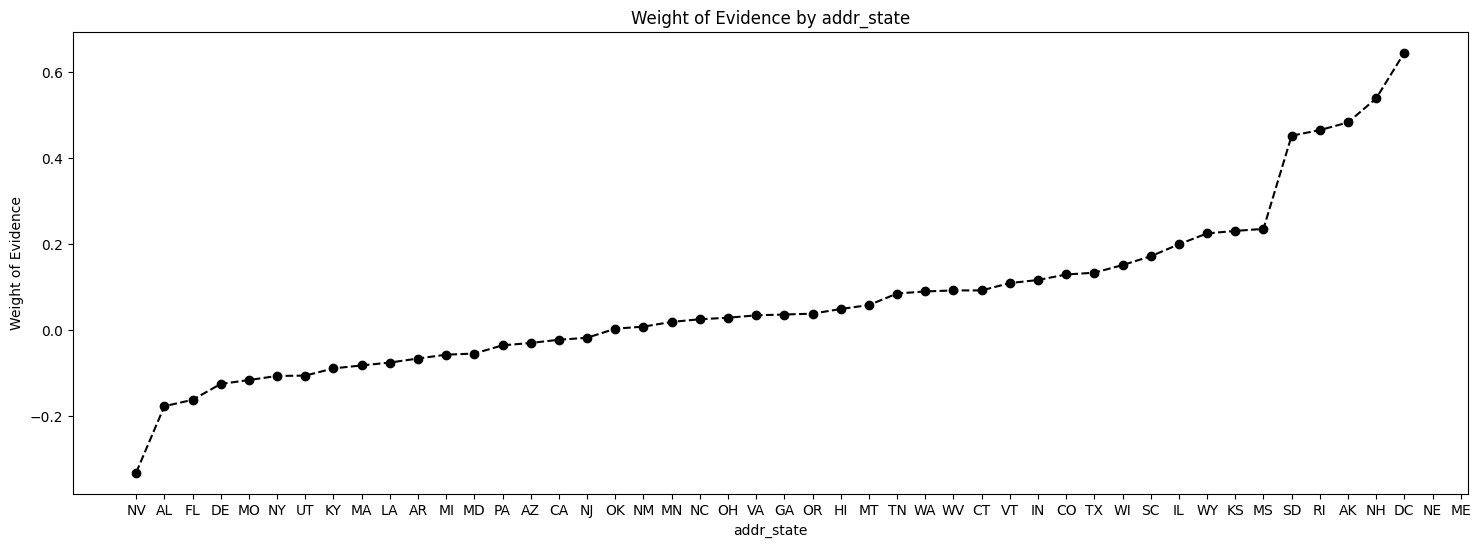

In [372]:
plot_by_woe(df_temp)

In [373]:
if ['addr_state:ND'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:ND'] = 0

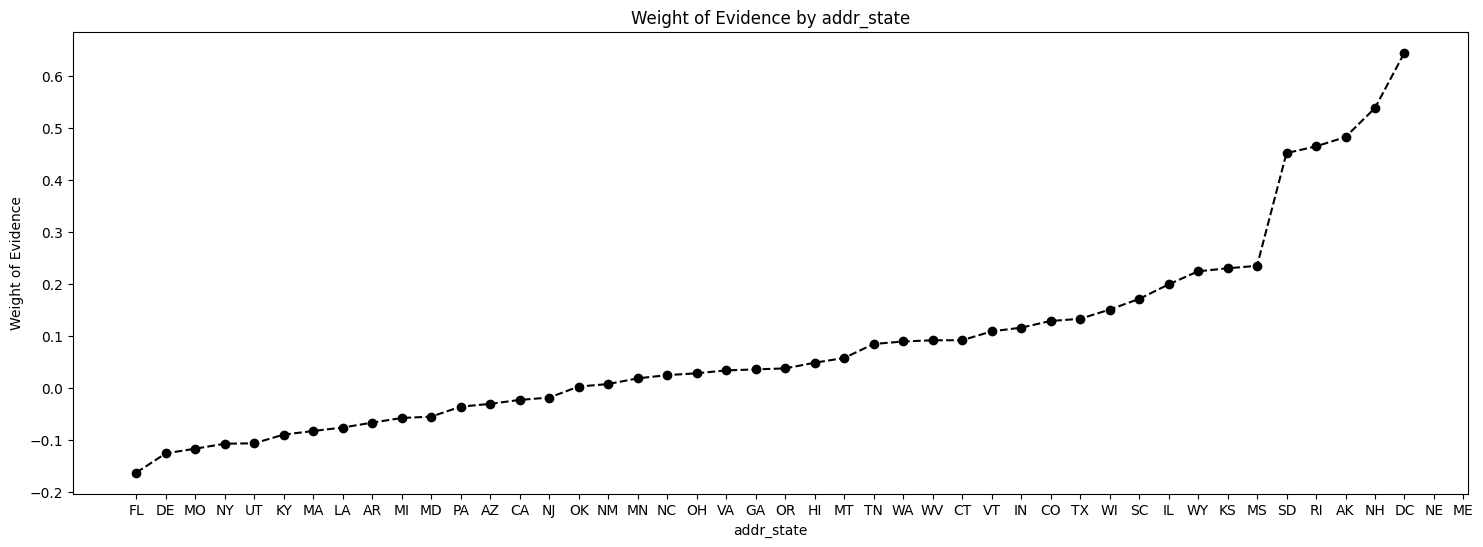

In [374]:
plot_by_woe(df_temp.iloc[2: -2, :])

In [375]:
# we will put NE, IA, NV, HI, FL, AL, ND (with 0 entries) in the same low WoE category
# 
# we will put ME, DC, WY, WV, VT, MS in the same high WoE category
#
# when we have no information, assume the worst, or highest risk

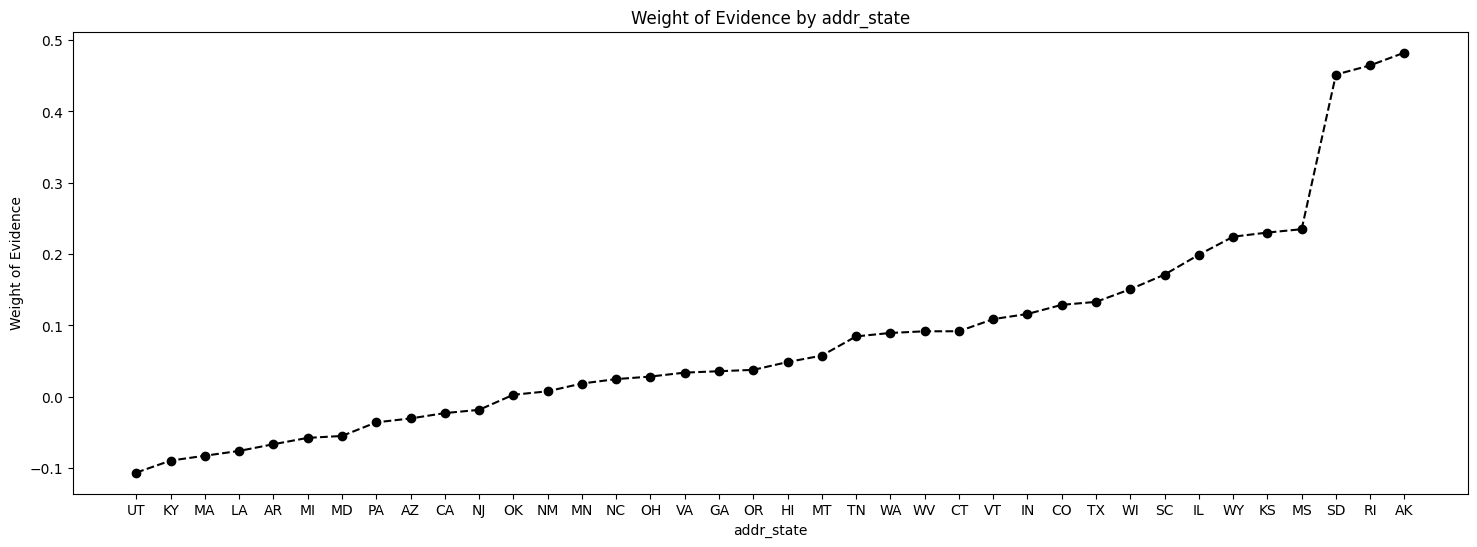

In [376]:
plot_by_woe(df_temp.iloc[6: -6, :])

In [377]:
# really large observations have to be kept in seperate dummy variables
# RI - LA in one category
# NY on its own
# MD - MO in one category
# CA on its own
# ID - TN in one category
# AZ - IN in one category
# KY - DE in one category
# OR - IL in one category
# TX on its own
# CT - AK in one category
# KS - NH in one category

In [378]:
df_inputs_prepr['addr_state:ND_NE_IA_NV_HI_FL_AL'] = sum([df_inputs_prepr['addr_state:ND'], df_inputs_prepr['addr_state:NE'],
                                                        df_inputs_prepr['addr_state:IA'], df_inputs_prepr['addr_state:NV'],
                                                        df_inputs_prepr['addr_state:HI'], df_inputs_prepr['addr_state:FL'],
                                                        df_inputs_prepr['addr_state:AL']])

df_inputs_prepr['addr_state:ME_DC_WY_WV_VT_MS'] = sum([df_inputs_prepr['addr_state:ME'], df_inputs_prepr['addr_state:DC'],
                                                        df_inputs_prepr['addr_state:WY'], df_inputs_prepr['addr_state:WV'],
                                                        df_inputs_prepr['addr_state:VT'], df_inputs_prepr['addr_state:MS']])

df_inputs_prepr['addr_state:RI_NM_NC_OK_SD_VA_LA'] = sum([df_inputs_prepr['addr_state:RI'], df_inputs_prepr['addr_state:NM'],
                                                        df_inputs_prepr['addr_state:NC'], df_inputs_prepr['addr_state:OK'],
                                                        df_inputs_prepr['addr_state:SD'], df_inputs_prepr['addr_state:VA'],
                                                        df_inputs_prepr['addr_state:LA']])

df_inputs_prepr['addr_state:MD_NJ_MO'] = sum([df_inputs_prepr['addr_state:MD'], df_inputs_prepr['addr_state:NJ'], df_inputs_prepr['addr_state:MO']])

df_inputs_prepr['addr_state:ID_TN'] = sum([df_inputs_prepr['addr_state:ID'], df_inputs_prepr['addr_state:TN']])

df_inputs_prepr['addr_state:AZ_MI_UT_AR_PA_OH_MN_IN'] = sum([df_inputs_prepr['addr_state:AZ'], df_inputs_prepr['addr_state:MI'],
                                                        df_inputs_prepr['addr_state:UT'], df_inputs_prepr['addr_state:AR'],
                                                        df_inputs_prepr['addr_state:PA'], df_inputs_prepr['addr_state:OH'],
                                                        df_inputs_prepr['addr_state:MN'], df_inputs_prepr['addr_state:IN']])

df_inputs_prepr['addr_state:KY_MA_GA_WA_WI_DE'] = sum([df_inputs_prepr['addr_state:KY'], df_inputs_prepr['addr_state:MA'],
                                                        df_inputs_prepr['addr_state:GA'], df_inputs_prepr['addr_state:WA'],
                                                        df_inputs_prepr['addr_state:WI'], df_inputs_prepr['addr_state:DE']])

df_inputs_prepr['addr_state:OR_IL'] = sum([df_inputs_prepr['addr_state:OR'], df_inputs_prepr['addr_state:IL']])

df_inputs_prepr['addr_state:CT_SC_AK'] = sum([df_inputs_prepr['addr_state:CT'], df_inputs_prepr['addr_state:SC'],
                                                        df_inputs_prepr['addr_state:AK']])

df_inputs_prepr['addr_state:KS_CO_MT_NH'] = sum([df_inputs_prepr['addr_state:KS'], df_inputs_prepr['addr_state:CO'],
                                                        df_inputs_prepr['addr_state:MT'], df_inputs_prepr['addr_state:NH']])

### Preprocessing remaining discrete variables: verification_status, purpose, initial_list_status

### verification_status

In [379]:
df_temp = woe_discrete(df_inputs_prepr, 'verification_status', df_targets_prepr)
df_temp

verification_status  n_obs  prop_good  prop_n_obs   n_good   n_bad  \
0            Verified  33590   0.872283    0.360187  29300.0  4290.0   
1     Source Verified  30193   0.899149    0.323761  27148.0  3045.0   
2        Not Verified  29474   0.906053    0.316051  26705.0  2769.0   

   prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  
0     0.352363    0.424584 -0.186450             NaN       NaN  0.022948  
1     0.326483    0.301366  0.080052        0.026865  0.266502  0.022948  
2     0.321155    0.274050  0.158614        0.006904  0.078562  0.022948

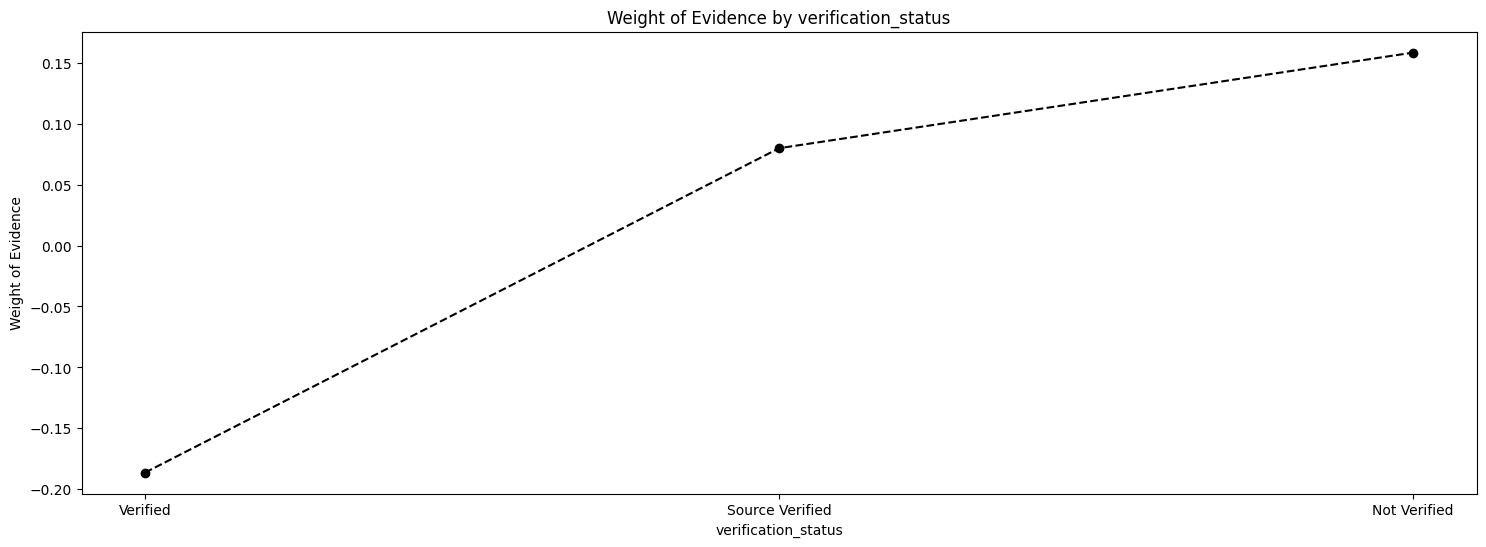

In [380]:
plot_by_woe(df_temp)

In [381]:
df_temp = woe_discrete(df_inputs_prepr, 'purpose', df_targets_prepr)
df_temp

purpose  n_obs  prop_good  prop_n_obs   n_good   n_bad  \
0       small_business   1399   0.781272    0.015002   1093.0   306.0   
1          educational     93   0.817204    0.000997     76.0    17.0   
2               moving    587   0.838160    0.006294    492.0    95.0   
3                other   4722   0.853664    0.050634   4031.0   691.0   
4                house    454   0.859031    0.004868    390.0    64.0   
5              wedding    456   0.859649    0.004890    392.0    64.0   
6              medical    931   0.860365    0.009983    801.0   130.0   
7     renewable_energy     75   0.866667    0.000804     65.0    10.0   
8             vacation    517   0.885880    0.005544    458.0    59.0   
9   debt_consolidation  54870   0.888482    0.588374  48751.0  6119.0   
10    home_improvement   5286   0.901627    0.056682   4766.0   520.0   
11      major_purchase   2016   0.904266    0.021618   1823.0   193.0   
12                 car   1036   0.912162    0.011109    945.0    91.0   
13         credit_card  20815   0.916166    0.223200  19070.0  1745.0   

    prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  
0      0.013144    0.030285 -0.834655             NaN       NaN  0.043474  
1      0.000914    0.001683 -0.610231        0.035932  0.224424  0.043474  
2      0.005917    0.009402 -0.463149        0.020956  0.147082  0.043474  
3      0.048477    0.068389 -0.344121        0.015504  0.119028  0.043474  
4      0.004690    0.006334 -0.300487        0.005367  0.043634  0.043474  
5      0.004714    0.006334 -0.295372        0.000618  0.005115  0.043474  
6      0.009633    0.012866 -0.289424        0.000716  0.005948  0.043474  
7      0.000782    0.000990 -0.235949        0.006301  0.053476  0.043474  
8      0.005508    0.005839 -0.058419        0.019213  0.177530  0.043474  
9      0.586281    0.605602 -0.032424        0.002602  0.025995  0.043474  
10     0.057316    0.051465  0.107683        0.013145  0.140107  0.043474  
11     0.021923    0.019101  0.137798        0.002639  0.030115  0.043474  
12     0.011365    0.009006  0.232575        0.007896  0.094777  0.043474  
13     0.229336    0.172704  0.283611        0.004004  0.051036  0.043474

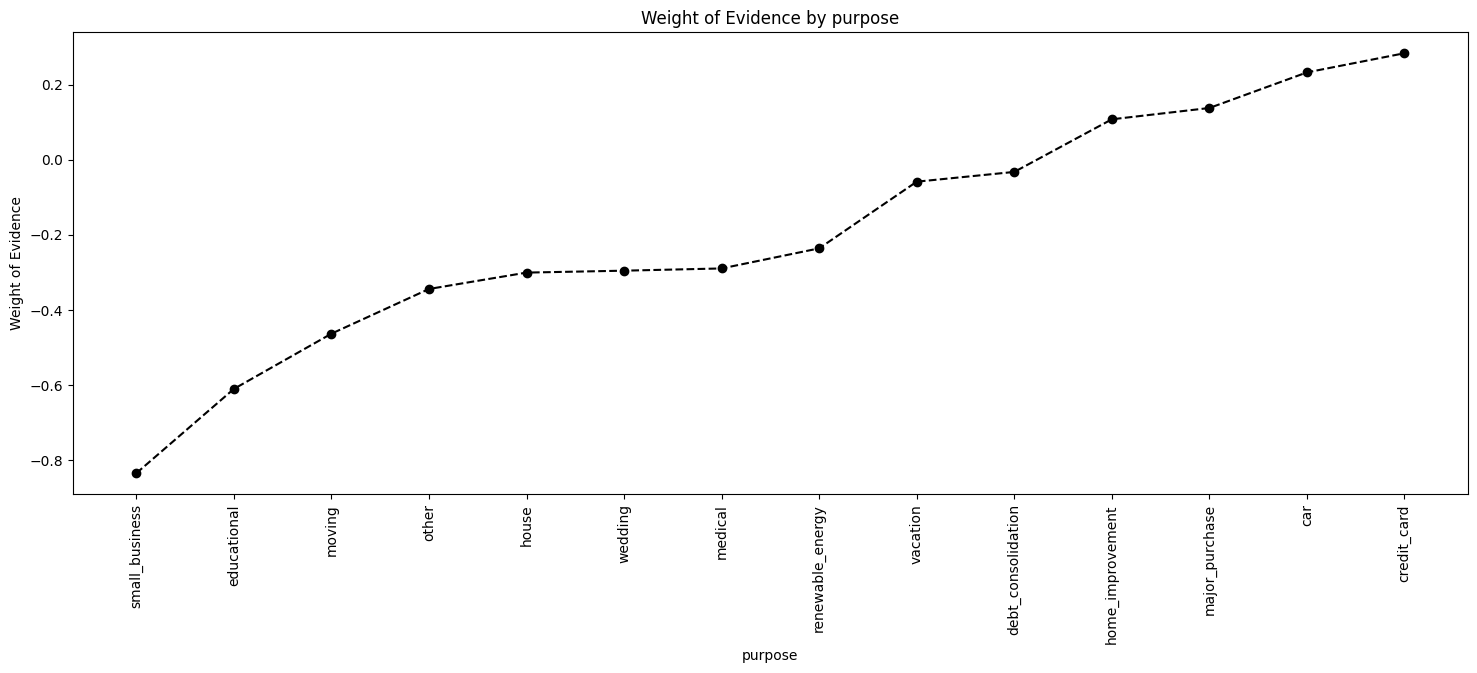

In [382]:
plot_by_woe(df_temp, 90)

In [383]:
# we put educational, small_business, renewable_energy, moving, house and other in one category (this will be the reference category)
# we put medical, wedding, vacation in one category
# we put debt_consolidation in its one category
# we put home_improvement, major_purchase and car in one category
# we put credit_card in one category

df_inputs_prepr['purpose:edu_sb_re_m_h_other'] = sum([df_inputs_prepr['purpose:educational'], df_inputs_prepr['purpose:small_business'],
                                                        df_inputs_prepr['purpose:renewable_energy'], df_inputs_prepr['purpose:moving'],
                                                        df_inputs_prepr['purpose:house'], df_inputs_prepr['purpose:other']])

df_inputs_prepr['purpose:med_wed_vac'] = sum([df_inputs_prepr['purpose:medical'], df_inputs_prepr['purpose:wedding'],
                                                        df_inputs_prepr['purpose:vacation']])

df_inputs_prepr['purpose:hi_mp_car'] = sum([df_inputs_prepr['purpose:home_improvement'], df_inputs_prepr['purpose:major_purchase'],
                                                        df_inputs_prepr['purpose:car']])

In [384]:
df_temp = woe_discrete(df_inputs_prepr, 'initial_list_status', df_targets_prepr)
df_temp

initial_list_status  n_obs  prop_good  prop_n_obs   n_good   n_bad  \
0                   f  60477   0.879855    0.648498  53211.0  7266.0   
1                   w  32780   0.913423    0.351502  29942.0  2838.0   

   prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  
0     0.639917    0.719121 -0.116692             NaN       NaN  0.028918  
1     0.360083    0.280879  0.248412        0.033568  0.365103  0.028918

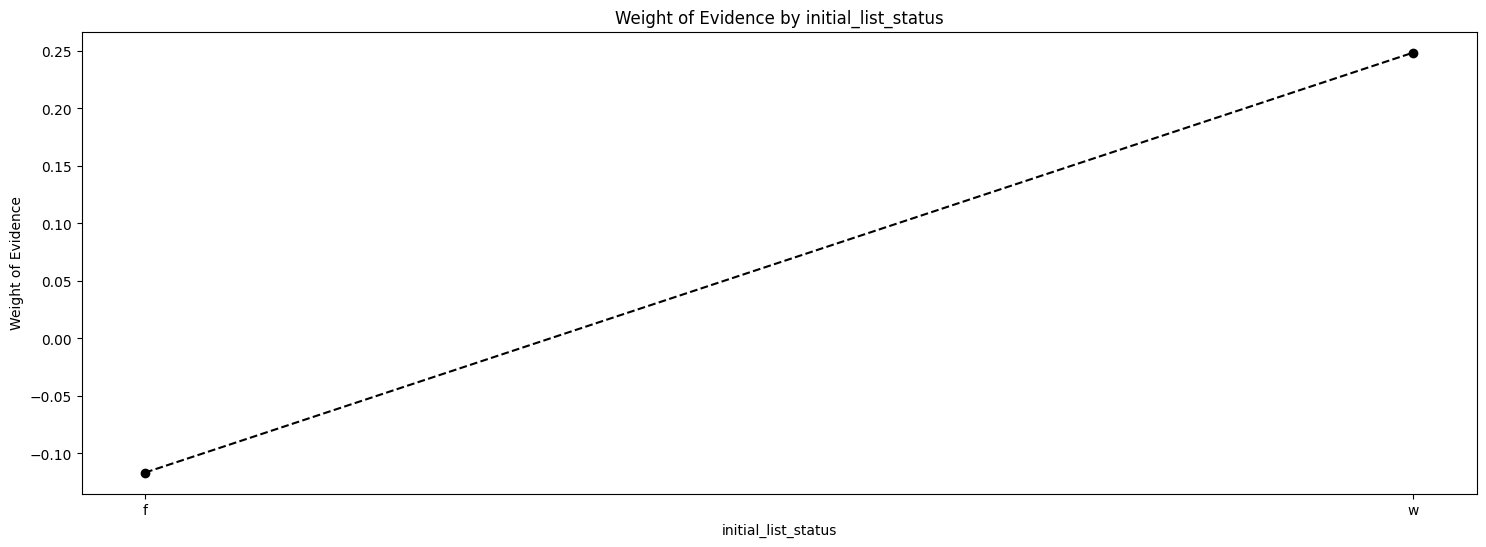

In [385]:
plot_by_woe(df_temp)

### Preprocessing continuous variables: Automating calculations and visualising results

In [386]:
def woe_ordered_continuous(df, discrete_variable_name, good_bad_variable_df):
    
    df = pd.concat([df[discrete_variable_name], good_bad_variable_df], axis=1)
    
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis=1)
    
    df = df.iloc[:, [0, 1, 3]]
    
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    
    return df

In [387]:
df_inputs_prepr['term_int'].unique()

array([36, 60], dtype=int64)

In [388]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'term_int', df_targets_prepr)
df_temp

term_int  n_obs  prop_good  prop_n_obs   n_good   n_bad  prop_n_good  \
0        36  67512   0.903336    0.723935  60986.0  6526.0     0.733419   
1        60  25745   0.861022    0.276065  22167.0  3578.0     0.266581   

   prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  
0    0.645883  0.127099             NaN       NaN  0.035982  
1    0.354117 -0.283950        0.042314  0.411049  0.035982

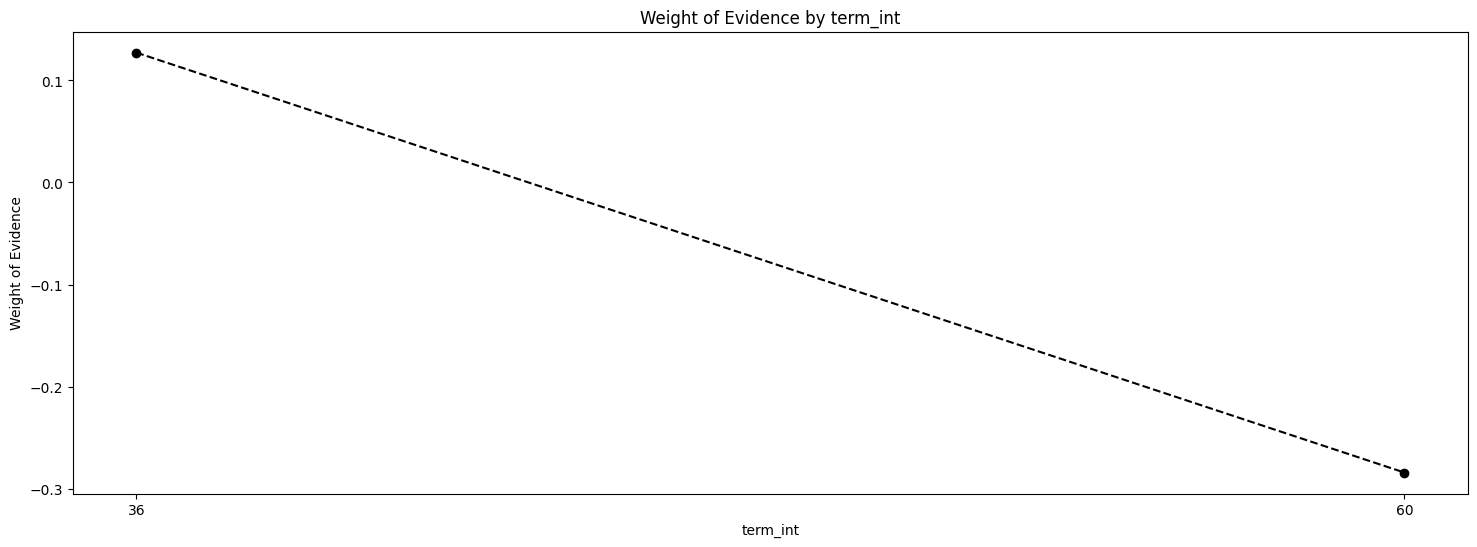

In [389]:
plot_by_woe(df_temp)

In [390]:
df_inputs_prepr['term:36'] = np.where((df_inputs_prepr['term_int']==36), 1, 0)
df_inputs_prepr['term:60'] = np.where((df_inputs_prepr['term_int']==60), 1, 0)

In [391]:
df_inputs_prepr['emp_length_int'].unique()

array([ 2, 10,  8,  7,  4,  9,  3,  6,  5,  1,  0], dtype=int64)

In [392]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'emp_length_int', df_targets_prepr)
df_temp

emp_length_int  n_obs  prop_good  prop_n_obs   n_good   n_bad  \
0                0  11511   0.874381    0.123433  10065.0  1446.0   
1                1   5793   0.894528    0.062119   5182.0   611.0   
2                2   8341   0.893058    0.089441   7449.0   892.0   
3                3   7444   0.888098    0.079822   6611.0   833.0   
4                4   5557   0.893648    0.059588   4966.0   591.0   
5                5   6064   0.888358    0.065025   5387.0   677.0   
6                6   5112   0.884781    0.054816   4523.0   589.0   
7                7   5152   0.884705    0.055245   4558.0   594.0   
8                8   4410   0.890023    0.047289   3925.0   485.0   
9                9   3664   0.882096    0.039289   3232.0   432.0   
10              10  30209   0.902215    0.323933  27255.0  2954.0   

    prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  
0      0.121042    0.143112 -0.167488             NaN       NaN  0.008958  
1      0.062319    0.060471  0.030099        0.020147  0.197586  0.008958  
2      0.089582    0.088282  0.014618        0.001469  0.015480  0.008958  
3      0.079504    0.082443 -0.036294        0.004961  0.050912  0.008958  
4      0.059721    0.058492  0.020803        0.005550  0.057097  0.008958  
5      0.064784    0.067003 -0.033678        0.005290  0.054481  0.008958  
6      0.054394    0.058294 -0.069246        0.003577  0.035568  0.008958  
7      0.054815    0.058789 -0.069991        0.000076  0.000745  0.008958  
8      0.047202    0.048001 -0.016778        0.005318  0.053213  0.008958  
9      0.038868    0.042755 -0.095320        0.007927  0.078542  0.008958  
10     0.327769    0.292359  0.114326        0.020119  0.209646  0.008958

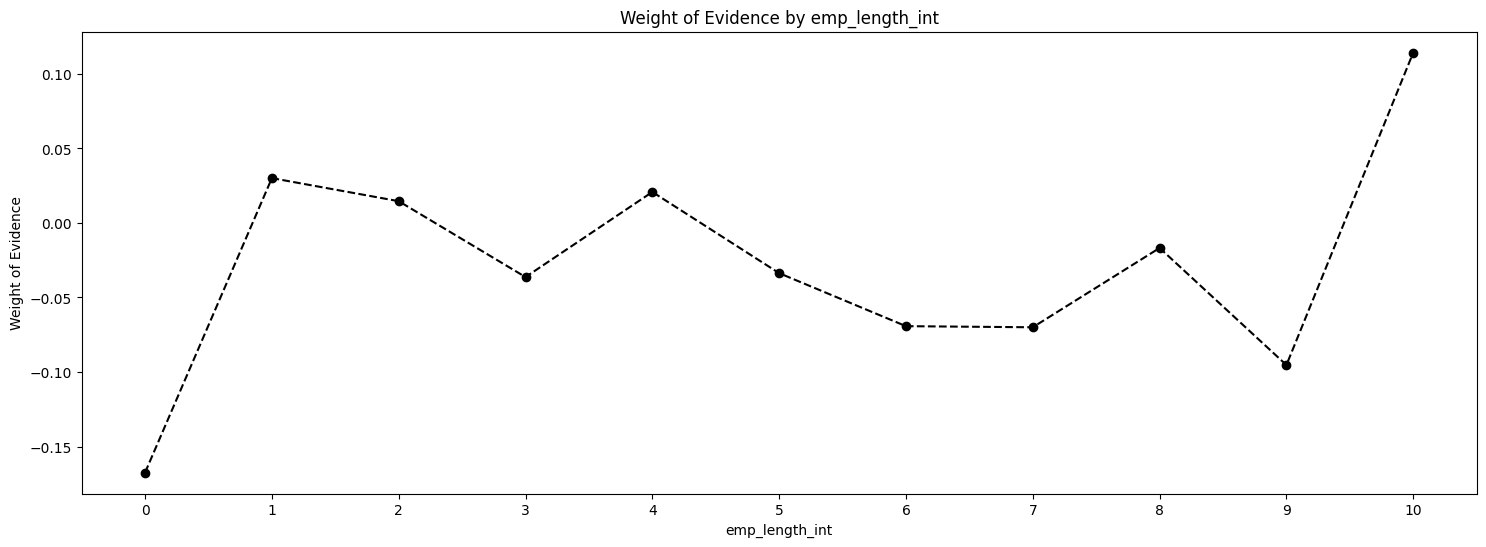

In [393]:
plot_by_woe(df_temp)

In [394]:
# 0 seperate (reference category)
# 1 seperate
# 2-4 together
# 5-6 together
# 7-9 together
# 10 seperate

df_inputs_prepr['emp_length:0'] = np.where(df_inputs_prepr['emp_length_int'].isin([0]), 1, 0)
df_inputs_prepr['emp_length:1'] = np.where(df_inputs_prepr['emp_length_int'].isin([1]), 1, 0)
df_inputs_prepr['emp_length:2-4'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(2, 5)), 1, 0)
df_inputs_prepr['emp_length:5-6'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(5, 7)), 1, 0)
df_inputs_prepr['emp_length:7-9'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(7, 10)), 1, 0)
df_inputs_prepr['emp_length:10'] = np.where(df_inputs_prepr['emp_length_int'].isin([10]), 1, 0)

In [395]:
df_inputs_prepr['mths_since_issue_d'].unique()

array([ 45.,  41.,  51.,  54.,  50.,  72.,  37.,  44.,  38.,  70.,  49.,
        62.,  89.,  46.,  47.,  53.,  68.,  58.,  56., 102., 103.,  59.,
        64.,  43.,  48.,  55.,  57.,  65.,  36.,  40.,  42.,  61.,  39.,
       112.,  52.,  75.,  60.,  71.,  93.,  90., 109.,  73., 124.,  81.,
        63.,  76.,  94.,  98.,  79.,  95.,  66.,  87.,  77.,  80., 118.,
        91.,  86.,  78.,  69.,  88.,  67.,  82.,  84., 117.,  74.,  83.,
        85., 119.,  97.,  96., 113., 107., 120., 100., 106., 121.,  99.,
       110., 104., 111., 105., 114., 101., 108., 115., 122.,  92., 123.,
       116., 125., 126.])

In [396]:
# using pd.cut(Series, number of categories)
# creates a new series with number of categories
# "factor" = categorical
df_inputs_prepr['mths_since_issue_d_factor'] = pd.cut(df_inputs_prepr['mths_since_issue_d'], 50)

In [397]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'mths_since_issue_d_factor', df_targets_prepr)
df_temp

mths_since_issue_d_factor  n_obs  prop_good  prop_n_obs  n_good  n_bad  \
0              (35.91, 37.8]   6985   0.944882    0.074901  6600.0  385.0   
1               (37.8, 39.6]   9991   0.929036    0.107134  9282.0  709.0   
2               (39.6, 41.4]   9624   0.920823    0.103199  8862.0  762.0   
3               (41.4, 43.2]   7182   0.910610    0.077013  6540.0  642.0   
4               (43.2, 45.0]   7096   0.902057    0.076091  6401.0  695.0   
5               (45.0, 46.8]   3076   0.900195    0.032984  2769.0  307.0   
6               (46.8, 48.6]   6197   0.896401    0.066451  5555.0  642.0   
7               (48.6, 50.4]   5714   0.888519    0.061272  5077.0  637.0   
8               (50.4, 52.2]   5175   0.883478    0.055492  4572.0  603.0   
9               (52.2, 54.0]   4439   0.867312    0.047600  3850.0  589.0   
10              (54.0, 55.8]   2118   0.864967    0.022711  1832.0  286.0   
11              (55.8, 57.6]   3569   0.867750    0.038271  3097.0  472.0   
12              (57.6, 59.4]   2956   0.860961    0.031697  2545.0  411.0   
13              (59.4, 61.2]   2444   0.852291    0.026207  2083.0  361.0   
14              (61.2, 63.0]   2533   0.844453    0.027161  2139.0  394.0   
15              (63.0, 64.8]   1050   0.852381    0.011259   895.0  155.0   
16              (64.8, 66.6]   1765   0.823796    0.018926  1454.0  311.0   
17              (66.6, 68.4]   1284   0.842679    0.013768  1082.0  202.0   
18              (68.4, 70.2]   1088   0.844669    0.011667   919.0  169.0   
19              (70.2, 72.0]    984   0.804878    0.010551   792.0  192.0   
20              (72.0, 73.8]    442   0.841629    0.004740   372.0   70.0   
21              (73.8, 75.6]    837   0.857826    0.008975   718.0  119.0   
22              (75.6, 77.4]    730   0.858904    0.007828   627.0  103.0   
23              (77.4, 79.2]    708   0.827684    0.007592   586.0  122.0   
24              (79.2, 81.0]    587   0.867121    0.006294   509.0   78.0   
25              (81.0, 82.8]    272   0.860294    0.002917   234.0   38.0   
26              (82.8, 84.6]    551   0.883848    0.005908   487.0   64.0   
27              (84.6, 86.4]    476   0.846639    0.005104   403.0   73.0   
28              (86.4, 88.2]    460   0.830435    0.004933   382.0   78.0   
29              (88.2, 90.0]    483   0.832298    0.005179   402.0   81.0   
30              (90.0, 91.8]    188   0.845745    0.002016   159.0   29.0   
31              (91.8, 93.6]    312   0.881410    0.003346   275.0   37.0   
32              (93.6, 95.4]    279   0.899642    0.002992   251.0   28.0   
33              (95.4, 97.2]    245   0.873469    0.002627   214.0   31.0   
34              (97.2, 99.0]    230   0.886957    0.002466   204.0   26.0   
35             (99.0, 100.8]     90   0.900000    0.000965    81.0    9.0   
36            (100.8, 102.6]    153   0.875817    0.001641   134.0   19.0   
37            (102.6, 104.4]    140   0.871429    0.001501   122.0   18.0   
38            (104.4, 106.2]    125   0.888000    0.001340   111.0   14.0   
39            (106.2, 108.0]    113   0.884956    0.001212   100.0   13.0   
40            (108.0, 109.8]     44   0.863636    0.000472    38.0    6.0   
41            (109.8, 111.6]     29   0.827586    0.000311    24.0    5.0   
42            (111.6, 113.4]     45   0.911111    0.000483    41.0    4.0   
43            (113.4, 115.2]     64   0.734375    0.000686    47.0   17.0   
44            (115.2, 117.0]    141   0.744681    0.001512   105.0   36.0   
45            (117.0, 118.8]     67   0.820896    0.000718    55.0   12.0   
46            (118.8, 120.6]     98   0.714286    0.001051    70.0   28.0   
47            (120.6, 122.4]     46   0.608696    0.000493    28.0   18.0   
48            (122.4, 124.2]     18   0.777778    0.000193    14.0    4.0   
49            (124.2, 126.0]     14   1.000000    0.000150    14.0    0.0   

    prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE   IV  
0   

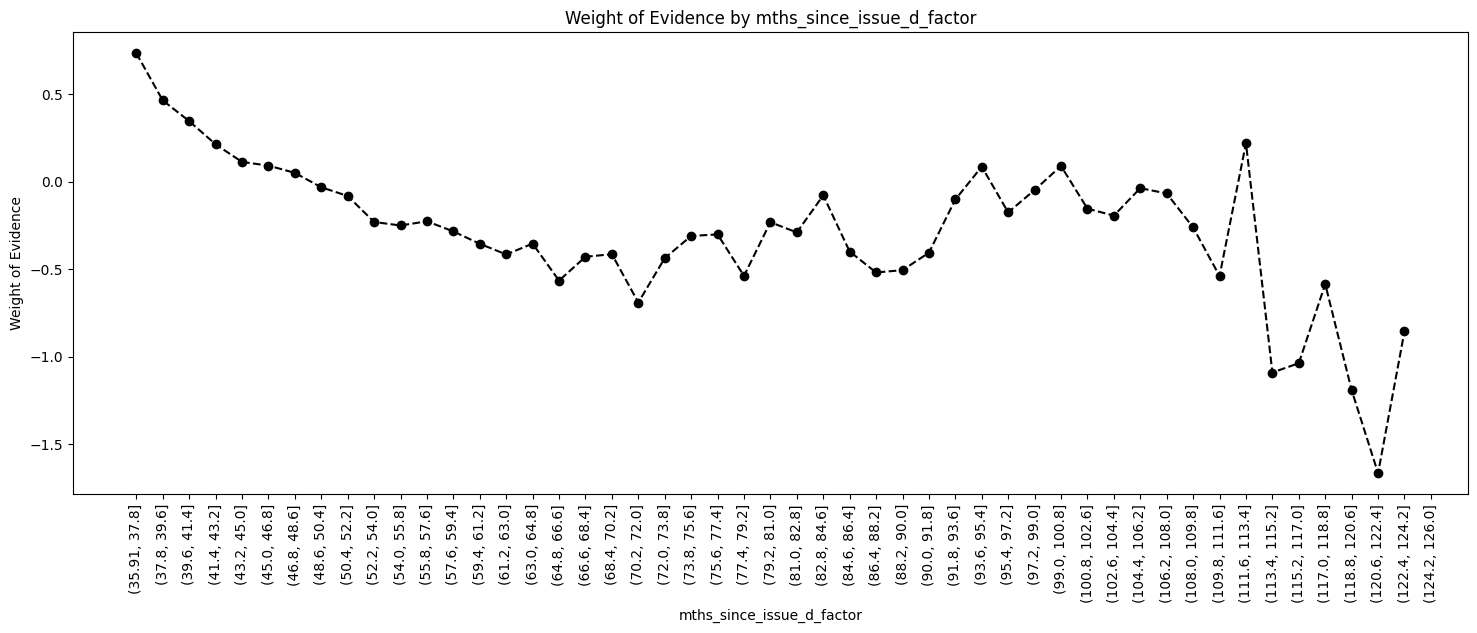

In [398]:
plot_by_woe(df_temp, 90)

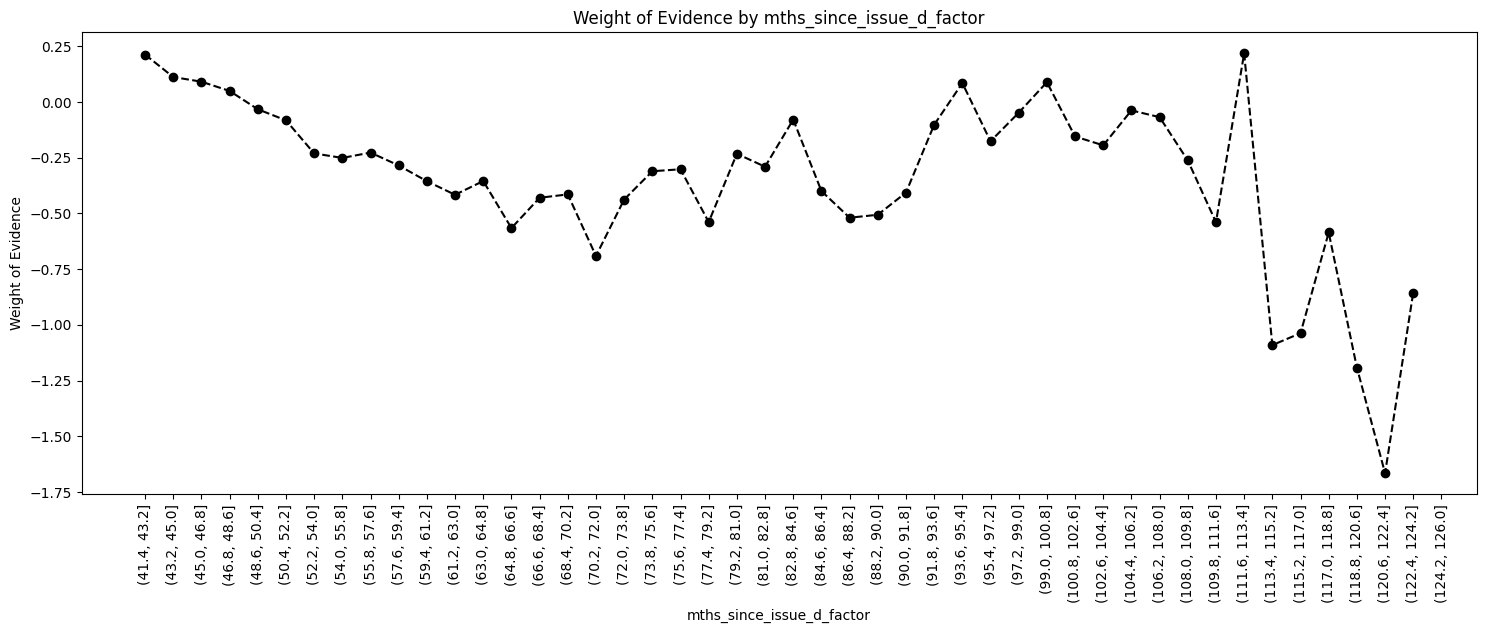

In [399]:
# first three all in seperate categories
# 4-6 in one category
# 6-10 in one category
# 11-22 in one category
# 22 + in one category
# the final ones are larger course classed because of less observations
plot_by_woe(df_temp.iloc[3:, :], 90)

In [400]:
df_inputs_prepr['mths_since_issue_d:<38'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38)), 1, 0)
df_inputs_prepr['mths_since_issue_d:38-39'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
df_inputs_prepr['mths_since_issue_d:<40-41'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
df_inputs_prepr['mths_since_issue_d:<40-41'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
df_inputs_prepr['mths_since_issue_d:<42-48'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
df_inputs_prepr['mths_since_issue_d:<49-52'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
df_inputs_prepr['mths_since_issue_d:<53-64'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
df_inputs_prepr['mths_since_issue_d:<65-84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
df_inputs_prepr['mths_since_issue_d:>84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(85, int(df_inputs_prepr['mths_since_issue_d'].max()))), 1, 0)

In [401]:
df_inputs_prepr['int_rate_factor'] = pd.cut(df_inputs_prepr['int_rate'], 50)

In [402]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'int_rate_factor', df_targets_prepr)
df_temp

int_rate_factor  n_obs  prop_good  prop_n_obs  n_good  n_bad  \
0     (5.399, 5.833]    188   0.973404    0.002016   183.0    5.0   
1     (5.833, 6.246]   2027   0.978786    0.021736  1984.0   43.0   
2     (6.246, 6.658]   1924   0.974012    0.020631  1874.0   50.0   
3     (6.658, 7.071]    452   0.977876    0.004847   442.0   10.0   
4     (7.071, 7.484]    786   0.978372    0.008428   769.0   17.0   
5     (7.484, 7.897]   3186   0.962649    0.034164  3067.0  119.0   
6      (7.897, 8.31]   2476   0.941438    0.026550  2331.0  145.0   
7      (8.31, 8.722]   1633   0.966932    0.017511  1579.0   54.0   
8     (8.722, 9.135]   2392   0.936873    0.025650  2241.0  151.0   
9     (9.135, 9.548]   1726   0.968134    0.018508  1671.0   55.0   
10    (9.548, 9.961]   1916   0.935804    0.020545  1793.0  123.0   
11   (9.961, 10.374]   2775   0.936937    0.029756  2600.0  175.0   
12  (10.374, 10.786]   1452   0.912534    0.015570  1325.0  127.0   
13  (10.786, 11.199]   4385   0.933637    0.047021  4094.0  291.0   
14  (11.199, 11.612]   1166   0.926244    0.012503  1080.0   86.0   
15  (11.612, 12.025]   3744   0.935630    0.040147  3503.0  241.0   
16  (12.025, 12.438]   3118   0.899936    0.033434  2806.0  312.0   
17   (12.438, 12.85]   2833   0.918814    0.030378  2603.0  230.0   
18   (12.85, 13.263]   5384   0.903232    0.057733  4863.0  521.0   
19  (13.263, 13.676]   3796   0.912276    0.040705  3463.0  333.0   
20  (13.676, 14.089]   2718   0.887049    0.029145  2411.0  307.0   
21  (14.089, 14.502]   5906   0.892482    0.063330  5271.0  635.0   
22  (14.502, 14.914]   1112   0.874101    0.011924   972.0  140.0   
23  (14.914, 15.327]   4683   0.888960    0.050216  4163.0  520.0   
24   (15.327, 15.74]   3059   0.888526    0.032802  2718.0  341.0   
25   (15.74, 16.153]   1924   0.841996    0.020631  1620.0  304.0   
26  (16.153, 16.566]   3229   0.858780    0.034625  2773.0  456.0   
27  (16.566, 16.978]   1033   0.842207    0.011077   870.0  163.0   
28  (16.978, 17.391]   2846   0.847505    0.030518  2412.0  434.0   
29  (17.391, 17.804]   3117   0.844722    0.033424  2633.0  484.0   
30  (17.804, 18.217]    305   0.826230    0.003271   252.0   53.0   
31   (18.217, 18.63]   2729   0.827776    0.029263  2259.0  470.0   
32   (18.63, 19.042]   1767   0.826825    0.018948  1461.0  306.0   
33  (19.042, 19.455]   1134   0.786596    0.012160   892.0  242.0   
34  (19.455, 19.868]   1721   0.812899    0.018454  1399.0  322.0   
35  (19.868, 20.281]   1231   0.851340    0.013200  1048.0  183.0   
36  (20.281, 20.694]    819   0.813187    0.008782   666.0  153.0   
37  (20.694, 21.106]    982   0.797352    0.010530   783.0  199.0   
38  (21.106, 21.519]    695   0.784173    0.007453   545.0  150.0   
39  (21.519, 21.932]    251   0.737052    0.002691   185.0   66.0   
40  (21.932, 22.345]    841   0.796671    0.009018   670.0  171.0   
41  (22.345, 22.758]    582   0.769759    0.006241   448.0  134.0   
42   (22.758, 23.17]    385   0.753247    0.004128   290.0   95.0   
43   (23.17, 23.583]    683   0.758419    0.007324   518.0  165.0   
44  (23.583, 23.996]    392   0.747449    0.004203   293.0   99.0   
45  (23.996, 24.409]    380   0.802632    0.004075   305.0   75.0   
46  (24.409, 24.822]    422   0.741706    0.004525   313.0  109.0   
47  (24.822, 25.234]    309   0.770227    0.003313   238.0   71.0   
48  (25.234, 25.647]    188   0.675532    0.002016   127.0   61.0   
49   (25.647, 26.06]    455   0.762637    0.004879   347.0  108.0   

    prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  
0      0.002201    0.000495  1.492297             NaN       NaN  0.357492  
1      0.023860    0.004256  1.723919        0.005382  0.231622  0.357492  
2      0.022537    0.004949  1.516057        0.004774  0.207863  0.357492  
3      0.005316    0.000990  1.680974        0.003864  0.164917  0.357492  
4      0.009248    0.001683  1.704127        0.000495  0.023153  0.357492  
5      0.036884    0.011778  

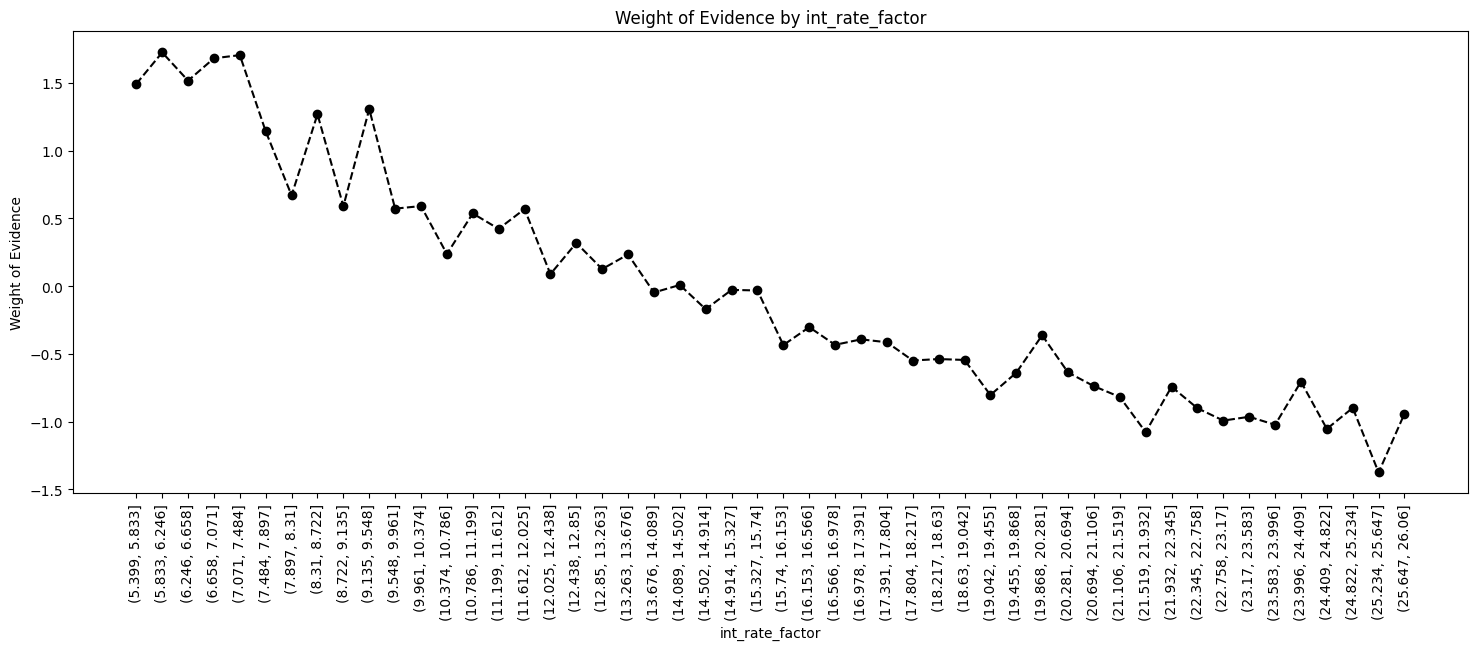

In [403]:
plot_by_woe(df_temp, 90)

In [404]:
# 5.4 - 9.548 in one category
# 9.548 - 12.025 in one category
# 12.025 - 15.74 in one category
# 15.74 - 20.281
# > 20.281
df_inputs_prepr['int_rate:<9.548'] = np.where((df_inputs_prepr['int_rate'] <= 9.548), 1, 0)
df_inputs_prepr['int_rate:9.548-12.025'] = np.where((df_inputs_prepr['int_rate'] > 9.548) & (df_inputs_prepr['int_rate'] <= 12.025), 1, 0)
df_inputs_prepr['int_rate:12.025-15.74'] = np.where((df_inputs_prepr['int_rate'] > 12.025) & (df_inputs_prepr['int_rate'] <= 15.74), 1, 0)
df_inputs_prepr['int_rate:15.74-20.281'] = np.where((df_inputs_prepr['int_rate'] > 15.74) & (df_inputs_prepr['int_rate'] <= 20.281), 1, 0)
df_inputs_prepr['int_rate:>20.281'] = np.where((df_inputs_prepr['int_rate'] > 20.281), 1, 0)

In [405]:
df_inputs_prepr['funded_amnt_factor'] = pd.cut(df_inputs_prepr['funded_amnt'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'funded_amnt_factor', df_targets_prepr)
df_temp

funded_amnt_factor  n_obs  prop_good  prop_n_obs  n_good  n_bad  \
0      (465.5, 1190.0]    337   0.902077    0.003614   304.0   33.0   
1     (1190.0, 1880.0]    780   0.893590    0.008364   697.0   83.0   
2     (1880.0, 2570.0]   1521   0.898751    0.016310  1367.0  154.0   
3     (2570.0, 3260.0]   1882   0.895855    0.020181  1686.0  196.0   
4     (3260.0, 3950.0]   1272   0.886792    0.013640  1128.0  144.0   
5     (3950.0, 4640.0]   2248   0.883007    0.024105  1985.0  263.0   
6     (4640.0, 5330.0]   3974   0.890287    0.042613  3538.0  436.0   
7     (5330.0, 6020.0]   4251   0.904728    0.045584  3846.0  405.0   
8     (6020.0, 6710.0]   1746   0.891180    0.018722  1556.0  190.0   
9     (6710.0, 7400.0]   2969   0.897272    0.031837  2664.0  305.0   
10    (7400.0, 8090.0]   4345   0.897583    0.046592  3900.0  445.0   
11    (8090.0, 8780.0]   1562   0.873880    0.016749  1365.0  197.0   
12    (8780.0, 9470.0]   2271   0.887274    0.024352  2015.0  256.0   
13   (9470.0, 10160.0]   8315   0.891882    0.089162  7416.0  899.0   
14  (10160.0, 10850.0]   1622   0.863748    0.017393  1401.0  221.0   
15  (10850.0, 11540.0]   2138   0.883536    0.022926  1889.0  249.0   
16  (11540.0, 12230.0]   5852   0.904135    0.062751  5291.0  561.0   
17  (12230.0, 12920.0]   1187   0.885425    0.012728  1051.0  136.0   
18  (12920.0, 13610.0]   1801   0.897279    0.019312  1616.0  185.0   
19  (13610.0, 14300.0]   2020   0.903465    0.021661  1825.0  195.0   
20  (14300.0, 14990.0]   1300   0.876923    0.013940  1140.0  160.0   
21  (14990.0, 15680.0]   5275   0.903697    0.056564  4767.0  508.0   
22  (15680.0, 16370.0]   2961   0.885849    0.031751  2623.0  338.0   
23  (16370.0, 17060.0]   1627   0.876460    0.017446  1426.0  201.0   
24  (17060.0, 17750.0]    860   0.863953    0.009222   743.0  117.0   
25  (17750.0, 18440.0]   2933   0.880668    0.031451  2583.0  350.0   
26  (18440.0, 19130.0]    916   0.870087    0.009822   797.0  119.0   
27  (19130.0, 19820.0]    968   0.873967    0.010380   846.0  122.0   
28  (19820.0, 20510.0]   5089   0.900373    0.054570  4582.0  507.0   
29  (20510.0, 21200.0]   1720   0.889535    0.018444  1530.0  190.0   
30  (21200.0, 21890.0]    559   0.846154    0.005994   473.0   86.0   
31  (21890.0, 22580.0]   1054   0.884250    0.011302   932.0  122.0   
32  (22580.0, 23270.0]    621   0.890499    0.006659   553.0   68.0   
33  (23270.0, 23960.0]    456   0.864035    0.004890   394.0   62.0   
34  (23960.0, 24650.0]   2487   0.903096    0.026668  2246.0  241.0   
35  (24650.0, 25340.0]   2536   0.907729    0.027194  2302.0  234.0   
36  (25340.0, 26030.0]    479   0.876827    0.005136   420.0   59.0   
37  (26030.0, 26720.0]    317   0.870662    0.003399   276.0   41.0   
38  (26720.0, 27410.0]    377   0.880637    0.004043   332.0   45.0   
39  (27410.0, 28100.0]   1702   0.901293    0.018251  1534.0  168.0   
40  (28100.0, 28790.0]    192   0.854167    0.002059   164.0   28.0   
41  (28790.0, 29480.0]    280   0.842857    0.003002   236.0   44.0   
42  (29480.0, 30170.0]   1879   0.885045    0.020149  1663.0  216.0   
43  (30170.0, 30860.0]    153   0.843137    0.001641   129.0   24.0   
44  (30860.0, 31550.0]    222   0.842342    0.002381   187.0   35.0   
45  (31550.0, 32240.0]    328   0.871951    0.003517   286.0   42.0   
46  (32240.0, 32930.0]    147   0.870748    0.001576   128.0   19.0   
47  (32930.0, 33620.0]    289   0.906574    0.003099   262.0   27.0   
48  (33620.0, 34310.0]    126   0.912698    0.001351   115.0   11.0   
49  (34310.0, 35000.0]   3311   0.889157    0.035504  2944.0  367.0   

    prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  
0      0.003656    0.003266  0.112769             NaN       NaN  0.014798  
1      0.008382    0.008215  0.020194        0.008487  0.092575  0.014798  
2      0.016440    0.015241  0.075670        0.005161  0.055476  0.014798  
3      0.020276    0.019398  0.044249        0.002895  0.031422  0.014798  
4 

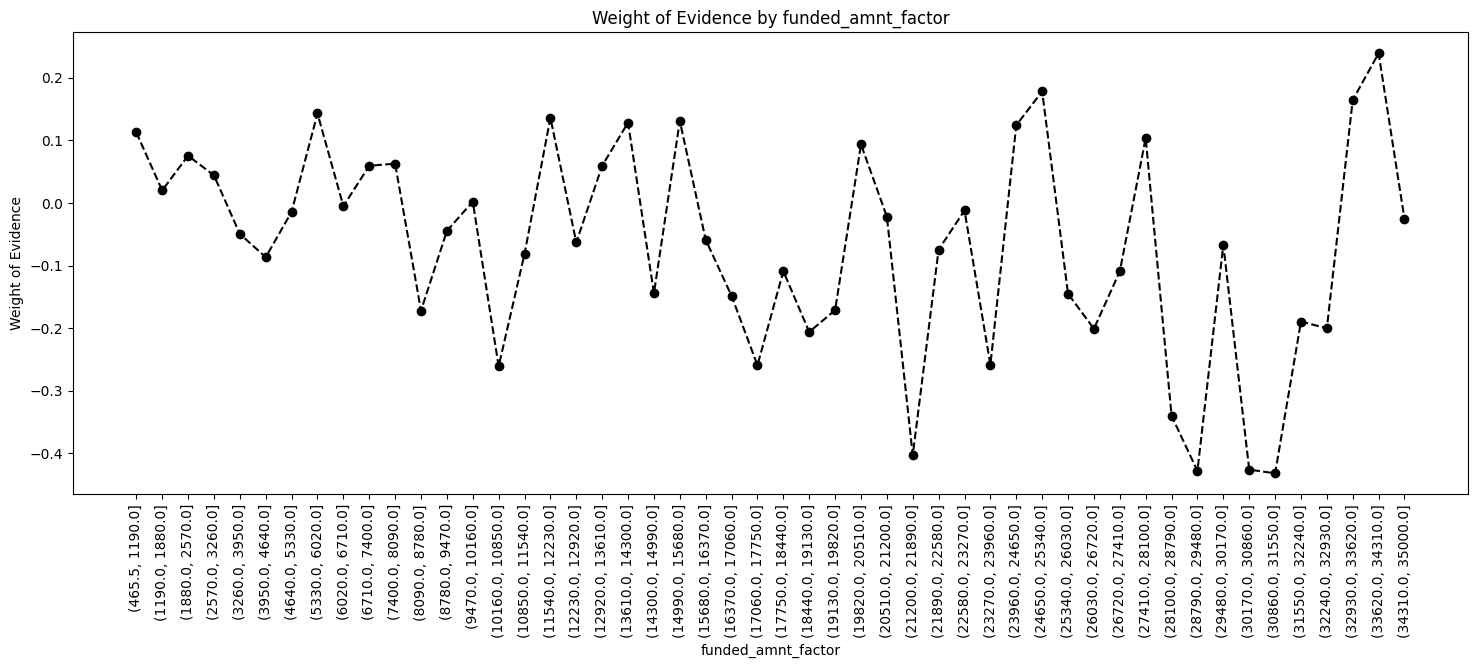

In [406]:
plot_by_woe(df_temp, 90)

In [407]:
# because the trend on weight of evidence is horizontal, it shows no association between the variable and the dependent var
# therefore reason to exclude this variable from the model

### Continuous variable processing (part 1):

#### 'mths_since_earliest_cr_line'

#### 'installment'

#### 'delinq_2yrs'

#### 'inq_last_6mths'

#### 'open_acc'

#### 'pub_rec'

#### 'total_acc'

#### 'acc_now_delinq'

In [408]:
df_inputs_prepr['mths_since_earliest_cr_line'].unique()

array([152., 352., 258., 312., 220., 305., 225., 380., 164., 165., 181.,
       121., 198., 328., 145., 203., 136., 221., 273., 243., 338., 137.,
       199., 229., 157., 381., 208., 168., 359.,  99., 280., 192., 256.,
       114., 239., 195., 161., 214., 139., 236., 245., 334., 178., 246.,
        88., 163., 238., 415., 291., 170., 336., 189., 146., 457., 268.,
       475., 249., 259., 123., 213., 194., 232., 128., 191., 124., 350.,
       348., 290., 204., 251., 233., 412., 347., 295., 440., 202., 200.,
       219., 153., 211., 300., 478., 374., 230., 196., 206., 118., 388.,
       224., 226., 270., 241., 100., 257., 283., 326., 265., 368., 403.,
       129., 364., 275., 179., 126., 188., 301., 134., 308., 311., 306.,
       429., 279., 176., 252., 215., 182., 560., 487., 266., 262., 167.,
       276., 216., 197., 177., 619., 255., 156., 201., 343., 228., 171.,
       223., 205., 131., 207., 227., 105., 271., 332., 371., 231., 218.,
       382., 186., 390., 184., 217.,  96., 174., 52

In [409]:
df_inputs_prepr['mths_since_earliest_cr_line_factor'] = pd.cut(df_inputs_prepr['mths_since_earliest_cr_line'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'mths_since_earliest_cr_line_factor', df_targets_prepr)
df_temp

mths_since_earliest_cr_line_factor  n_obs  prop_good  prop_n_obs  n_good  \
0                     (-0.806, 16.12]      4   1.000000    0.000043     4.0   
1                      (16.12, 32.24]      0        NaN    0.000000     NaN   
2                      (32.24, 48.36]      0        NaN    0.000000     NaN   
3                      (48.36, 64.48]      0        NaN    0.000000     NaN   
4                       (64.48, 80.6]    107   0.887850    0.001147    95.0   
5                       (80.6, 96.72]    663   0.873303    0.007109   579.0   
6                     (96.72, 112.84]   1176   0.886905    0.012610  1043.0   
7                    (112.84, 128.96]   2762   0.866401    0.029617  2393.0   
8                    (128.96, 145.08]   4419   0.866033    0.047385  3827.0   
9                     (145.08, 161.2]   5076   0.878054    0.054430  4457.0   
10                    (161.2, 177.32]   6137   0.884797    0.065807  5430.0   
11                   (177.32, 193.44]   7590   0.885112    0.081388  6718.0   
12                   (193.44, 209.56]   9587   0.884427    0.102802  8479.0   
13                   (209.56, 225.68]   8763   0.890677    0.093966  7805.0   
14                    (225.68, 241.8]   7564   0.890270    0.081109  6734.0   
15                    (241.8, 257.92]   6304   0.898953    0.067598  5667.0   
16                   (257.92, 274.04]   6083   0.891665    0.065228  5424.0   
17                   (274.04, 290.16]   5182   0.903898    0.055567  4684.0   
18                   (290.16, 306.28]   3537   0.903591    0.037927  3196.0   
19                    (306.28, 322.4]   2664   0.907282    0.028566  2417.0   
20                    (322.4, 338.52]   2934   0.907635    0.031461  2663.0   
21                   (338.52, 354.64]   2455   0.910794    0.026325  2236.0   
22                   (354.64, 370.76]   2046   0.903715    0.021939  1849.0   
23                   (370.76, 386.88]   1635   0.909480    0.017532  1487.0   
24                    (386.88, 403.0]   1469   0.909462    0.015752  1336.0   
25                    (403.0, 419.12]   1121   0.895629    0.012021  1004.0   
26                   (419.12, 435.24]    804   0.917910    0.008621   738.0   
27                   (435.24, 451.36]    560   0.917857    0.006005   514.0   
28                   (451.36, 467.48]    538   0.910781    0.005769   490.0   
29                    (467.48, 483.6]    508   0.925197    0.005447   470.0   
30                    (483.6, 499.72]    372   0.889785    0.003989   331.0   
31                   (499.72, 515.84]    261   0.915709    0.002799   239.0   
32                   (515.84, 531.96]    212   0.910377    0.002273   193.0   
33                   (531.96, 548.08]    193   0.922280    0.002070   178.0   
34                    (548.08, 564.2]    117   0.914530    0.001255   107.0   
35                    (564.2, 580.32]    115   0.965217    0.001233   111.0   
36                   (580.32, 596.44]     78   0.897436    0.000836    70.0   
37                   (596.44, 612.56]     68   0.779412    0.000729    53.0   
38                   (612.56, 628.68]     55   0.909091    0.000590    50.0   
39                    (628.68, 644.8]     31   0.838710    0.000332    26.0   
40                    (644.8, 660.92]     29   0.862069    0.000311    25.0   
41                   (660.92, 677.04]     10   0.900000    0.000107     9.0   
42                   (677.04, 693.16]      5   0.600000    0.000054     3.0   
43                   (693.16, 709.28]      9   0.888889    0.000097     8.0   
44                    (709.28, 725.4]      3   1.000000    0.000032     3.0   
45                    (725.4, 741.52]      2   0.500000    0.000021     1.0   
46                   (741.52, 757.64]      5   0.600000    0.000054     3.0   
47                   (757.64, 773.76]      1   1.000000    0.000011     1.0   
48                   (773.76, 789.88]      0        NaN    0.000000     NaN   
49                    (789.88, 806.0]      3   1.0000

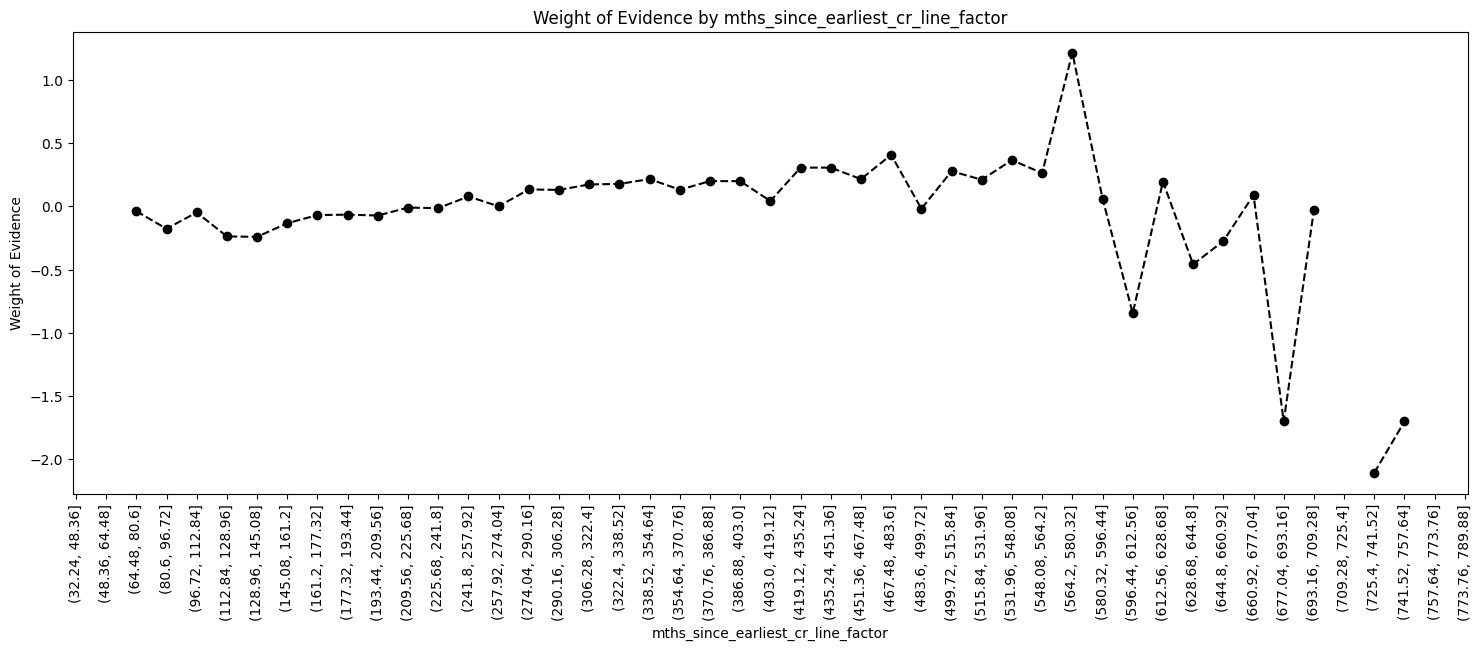

In [410]:
plot_by_woe(df_temp, 90)

In [411]:
# < 141.92
# 141.92 - 266.1
# 266.1 - 354.8
# > 354.8

df_inputs_prepr['mths_since_earliest_cr_line:<142'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(142)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:142-266'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(142, 266)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:266-355'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(266, 355)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:>355'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(355, int(df_inputs_prepr['mths_since_earliest_cr_line'].max()))), 1, 0)

In [412]:
df_inputs_prepr['installment'].unique()

array([535.19, 587.34, 540.25, ..., 165.21, 130.86, 418.35])

In [413]:
df_inputs_prepr['installment_factor'] = pd.cut(df_inputs_prepr['installment'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'installment_factor', df_targets_prepr)
df_temp

installment_factor  n_obs  prop_good  prop_n_obs  n_good  n_bad  \
0       (15.459, 44.676]    529   0.896030    0.005672   474.0   55.0   
1       (44.676, 72.501]   1265   0.888538    0.013565  1124.0  141.0   
2      (72.501, 100.327]   1762   0.902384    0.018894  1590.0  172.0   
3     (100.327, 128.152]   2338   0.897348    0.025071  2098.0  240.0   
4     (128.152, 155.978]   2646   0.883220    0.028373  2337.0  309.0   
5     (155.978, 183.804]   4146   0.893150    0.044458  3703.0  443.0   
6     (183.804, 211.629]   4188   0.905922    0.044908  3794.0  394.0   
7     (211.629, 239.455]   3879   0.892498    0.041595  3462.0  417.0   
8      (239.455, 267.28]   4672   0.904110    0.050098  4224.0  448.0   
9      (267.28, 295.106]   4948   0.887833    0.053058  4393.0  555.0   
10    (295.106, 322.932]   4955   0.900908    0.053133  4464.0  491.0   
11    (322.932, 350.757]   6362   0.893115    0.068220  5682.0  680.0   
12    (350.757, 378.583]   4624   0.885164    0.049583  4093.0  531.0   
13    (378.583, 406.408]   4550   0.890989    0.048790  4054.0  496.0   
14    (406.408, 434.234]   3291   0.876633    0.035290  2885.0  406.0   
15     (434.234, 462.06]   3128   0.889066    0.033542  2781.0  347.0   
16     (462.06, 489.885]   3850   0.904156    0.041284  3481.0  369.0   
17    (489.885, 517.711]   3892   0.895683    0.041734  3486.0  406.0   
18    (517.711, 545.536]   2720   0.865809    0.029167  2355.0  365.0   
19    (545.536, 573.362]   2596   0.888675    0.027837  2307.0  289.0   
20    (573.362, 601.188]   2411   0.873082    0.025853  2105.0  306.0   
21    (601.188, 629.013]   2415   0.904348    0.025896  2184.0  231.0   
22    (629.013, 656.839]   2096   0.895992    0.022476  1878.0  218.0   
23    (656.839, 684.664]   2336   0.897688    0.025049  2097.0  239.0   
24     (684.664, 712.49]   1546   0.880336    0.016578  1361.0  185.0   
25     (712.49, 740.316]   1210   0.880992    0.012975  1066.0  144.0   
26    (740.316, 768.141]   1378   0.888244    0.014776  1224.0  154.0   
27    (768.141, 795.967]   1220   0.909836    0.013082  1110.0  110.0   
28    (795.967, 823.792]   1024   0.890625    0.010980   912.0  112.0   
29    (823.792, 851.618]    883   0.896942    0.009468   792.0   91.0   
30    (851.618, 879.444]   1122   0.887701    0.012031   996.0  126.0   
31    (879.444, 907.269]    787   0.883100    0.008439   695.0   92.0   
32    (907.269, 935.095]    542   0.857934    0.005812   465.0   77.0   
33     (935.095, 962.92]    592   0.880068    0.006348   521.0   71.0   
34     (962.92, 990.746]    500   0.846000    0.005362   423.0   77.0   
35   (990.746, 1018.572]    406   0.859606    0.004354   349.0   57.0   
36  (1018.572, 1046.397]    309   0.877023    0.003313   271.0   38.0   
37  (1046.397, 1074.223]    215   0.893023    0.002305   192.0   23.0   
38  (1074.223, 1102.048]    237   0.886076    0.002541   210.0   27.0   
39  (1102.048, 1129.874]    223   0.923767    0.002391   206.0   17.0   
40    (1129.874, 1157.7]    236   0.911017    0.002531   215.0   21.0   
41    (1157.7, 1185.525]    275   0.912727    0.002949   251.0   24.0   
42  (1185.525, 1213.351]    327   0.926606    0.003506   303.0   24.0   
43  (1213.351, 1241.176]    269   0.925651    0.002885   249.0   20.0   
44  (1241.176, 1269.002]    140   0.828571    0.001501   116.0   24.0   
45  (1269.002, 1296.828]    122   0.836066    0.001308   102.0   20.0   
46  (1296.828, 1324.653]     46   0.826087    0.000493    38.0    8.0   
47  (1324.653, 1352.479]     21   0.761905    0.000225    16.0    5.0   
48  (1352.479, 1380.304]     20   0.650000    0.000214    13.0    7.0   
49   (1380.304, 1408.13]      8   0.750000    0.000086     6.0    2.0   

    prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  
0      0.005700    0.005443  0.046123             NaN       NaN  0.015457  
1      0.013517    0.013955 -0.031862        0.007493  0.077985  0.015457  
2      0.019121    0.017023  0.116244        0.013846 

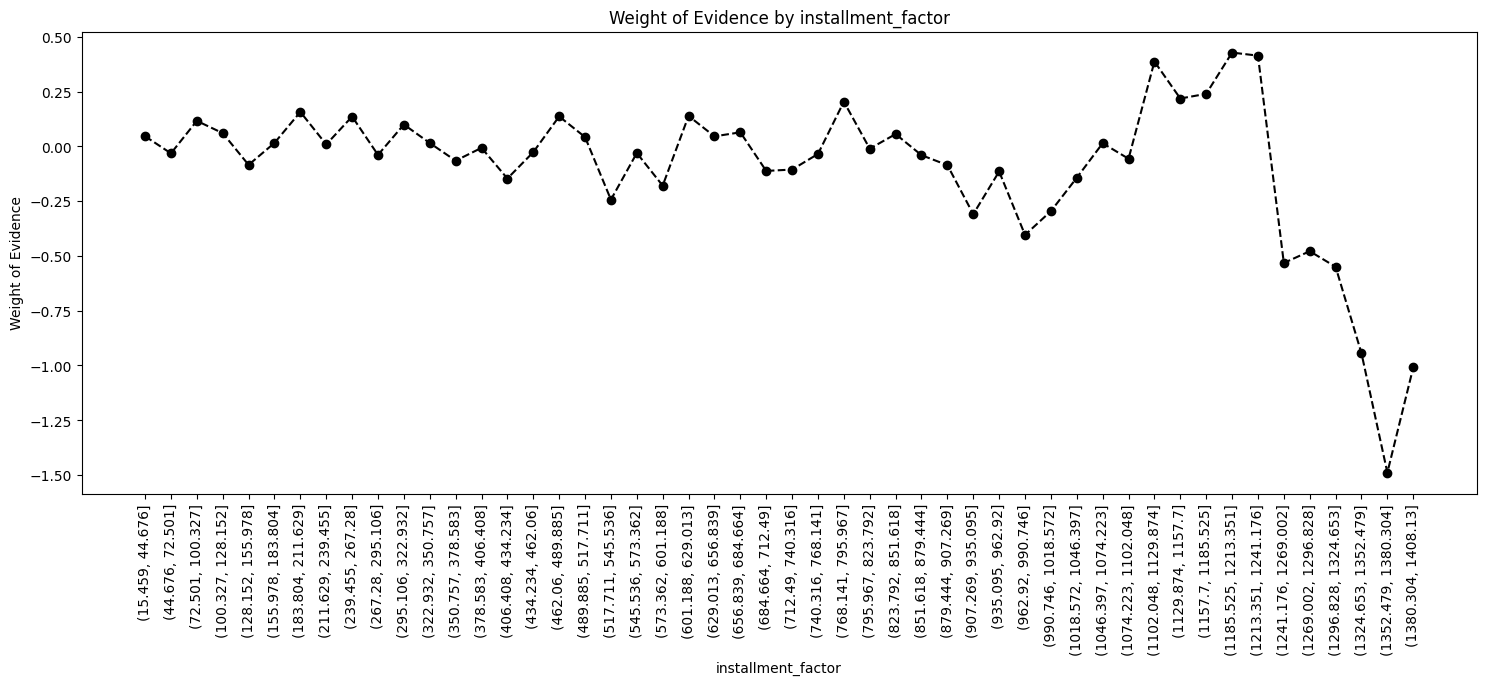

In [414]:
plot_by_woe(df_temp, 90)

In [415]:
# installment mostly unrelated to WoE

In [416]:
df_inputs_prepr['delinq_2yrs'].unique()

array([ 2.,  1.,  0.,  3.,  4.,  5.,  8., 10.,  6., 12.,  7., 15., 11.,
        9., 18., 22., 16., 13., 19., 21.])

In [417]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'delinq_2yrs', df_targets_prepr)
df_temp

delinq_2yrs  n_obs  prop_good  prop_n_obs   n_good   n_bad  prop_n_good  \
0           0.0  76613   0.891729    0.821525  68318.0  8295.0     0.821594   
1           1.0  11222   0.893869    0.120334  10031.0  1191.0     0.120633   
2           2.0   3230   0.882663    0.034635   2851.0   379.0     0.034286   
3           3.0   1147   0.882302    0.012299   1012.0   135.0     0.012170   
4           4.0    487   0.907598    0.005222    442.0    45.0     0.005316   
5           5.0    256   0.910156    0.002745    233.0    23.0     0.002802   
6           6.0    120   0.875000    0.001287    105.0    15.0     0.001263   
7           7.0     82   0.878049    0.000879     72.0    10.0     0.000866   
8           8.0     41   0.829268    0.000440     34.0     7.0     0.000409   
9           9.0     13   1.000000    0.000139     13.0     0.0     0.000156   
10         10.0     18   0.944444    0.000193     17.0     1.0     0.000204   
11         11.0     10   1.000000    0.000107     10.0     0.0     0.000120   
12         12.0      9   0.666667    0.000097      6.0     3.0     0.000072   
13         13.0      1   1.000000    0.000011      1.0     0.0     0.000012   
14         15.0      2   1.000000    0.000021      2.0     0.0     0.000024   
15         16.0      1   1.000000    0.000011      1.0     0.0     0.000012   
16         18.0      2   1.000000    0.000021      2.0     0.0     0.000024   
17         19.0      1   1.000000    0.000011      1.0     0.0     0.000012   
18         21.0      1   1.000000    0.000011      1.0     0.0     0.000012   
19         22.0      1   1.000000    0.000011      1.0     0.0     0.000012   

    prop_n_bad       WoE  diff_prop_good  diff_WoE   IV  
0     0.820962  0.000769             NaN       NaN  inf  
1     0.117874  0.023136        0.002141  0.022367  inf  
2     0.037510 -0.089862        0.011207  0.112998  inf  
3     0.013361 -0.093342        0.000361  0.003480  inf  
4     0.004454  0.176896        0.025296  0.270238  inf  
5     0.002276  0.207793        0.002559  0.030897  inf  
6     0.001485 -0.161841        0.035156  0.369634  inf  
7     0.000990 -0.133670        0.003049  0.028171  inf  
8     0.000693 -0.527301        0.048780  0.393631  inf  
9     0.000000       inf        0.170732       inf  inf  
10    0.000099  0.725462        0.055556       inf  inf  
11    0.000000       inf        0.055556       inf  inf  
12    0.000297 -1.414604        0.333333       inf  inf  
13    0.000000       inf        0.333333       inf  inf  
14    0.000000       inf        0.000000       NaN  inf  
15    0.000000       inf        0.000000       NaN  inf  
16    0.000000       inf        0.000000       NaN  inf  
17    0.000000       inf        0.000000       NaN  inf  
18    0.000000       inf        0.000000       NaN  inf  
19    0.000000       inf        0.000000       NaN  inf

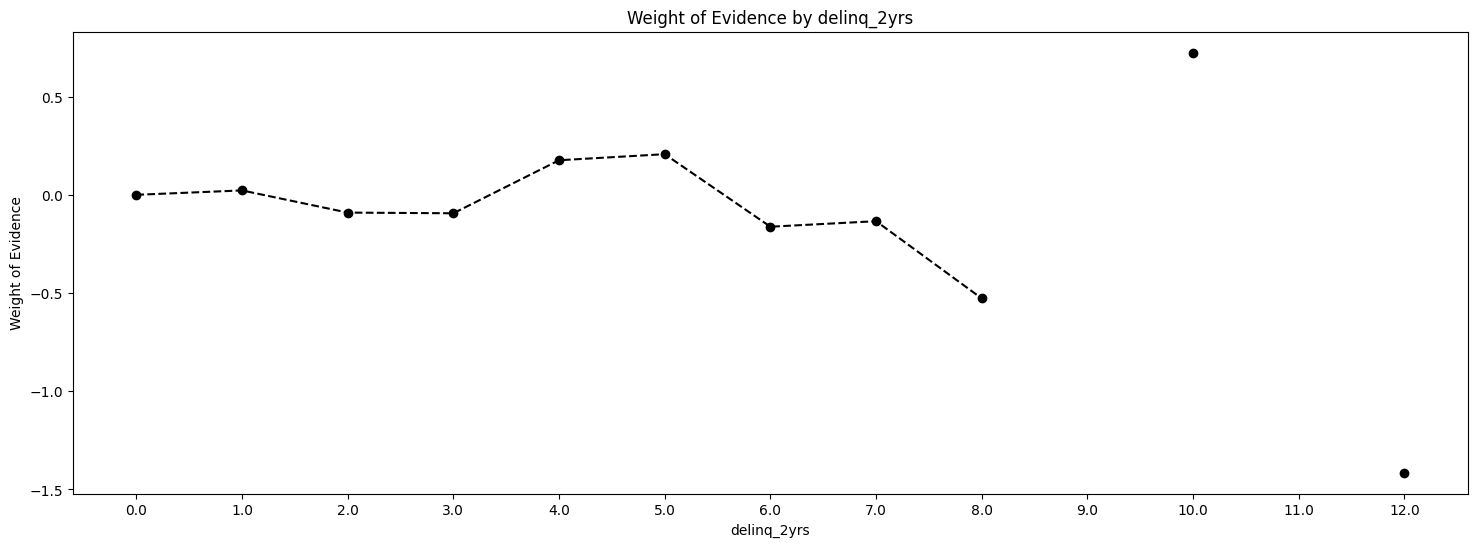

In [418]:
plot_by_woe(df_temp)

In [419]:
df_inputs_prepr['delinq_2yrs:0'] = np.where((df_inputs_prepr['delinq_2yrs'] == 0), 1, 0)
df_inputs_prepr['delinq_2yrs:1-3'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 1) & (df_inputs_prepr['delinq_2yrs'] <= 3), 1, 0)
df_inputs_prepr['delinq_2yrs:>=4'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 4), 1, 0)

In [420]:
df_inputs_prepr['inq_last_6mths'].unique()

array([ 1.,  0.,  5.,  4.,  2.,  3., 10.,  6.,  8., 11., 12.,  7., 15.,
        9., 14., 19., 25.])

In [421]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'inq_last_6mths', df_targets_prepr)
df_temp

C:\WPy64-31101\python-3.11.0.amd64\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


inq_last_6mths  n_obs  prop_good  prop_n_obs   n_good   n_bad  \
0              0.0  48471   0.909451    0.519757  44082.0  4389.0   
1              1.0  25975   0.886930    0.278531  23038.0  2937.0   
2              2.0  11530   0.862099    0.123637   9940.0  1590.0   
3              3.0   4984   0.839085    0.053444   4182.0   802.0   
4              4.0   1380   0.851449    0.014798   1175.0   205.0   
5              5.0    552   0.847826    0.005919    468.0    84.0   
6              6.0    260   0.773077    0.002788    201.0    59.0   
7              7.0     46   0.717391    0.000493     33.0    13.0   
8              8.0     27   0.481481    0.000290     13.0    14.0   
9              9.0      8   0.625000    0.000086      5.0     3.0   
10            10.0      8   1.000000    0.000086      8.0     0.0   
11            11.0      3   0.666667    0.000032      2.0     1.0   
12            12.0      6   0.666667    0.000064      4.0     2.0   
13            14.0      2   0.000000    0.000021      0.0     2.0   
14            15.0      3   0.333333    0.000032      1.0     2.0   
15            19.0      1   1.000000    0.000011      1.0     0.0   
16            25.0      1   0.000000    0.000011      0.0     1.0   

    prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE   IV  
0      0.530131    0.434382  0.199199             NaN       NaN  inf  
1      0.277056    0.290677 -0.047995        0.022521  0.247194  inf  
2      0.119539    0.157363 -0.274918        0.024831  0.226923  inf  
3      0.050293    0.079375 -0.456315        0.023014  0.181397  inf  
4      0.014131    0.020289 -0.361737        0.012364  0.094577  inf  
5      0.005628    0.008314 -0.390099        0.003623  0.028362  inf  
6      0.002417    0.005839 -0.881983        0.074749  0.491884  inf  
7      0.000397    0.001287 -1.176193        0.055686  0.294209  inf  
8      0.000156    0.001386 -2.181859        0.235910  1.005666  inf  
9      0.000060    0.000297 -1.596925        0.143519  0.584934  inf  
10     0.000096    0.000000       inf        0.375000       inf  inf  
11     0.000024    0.000099 -1.414604        0.333333       inf  inf  
12     0.000048    0.000198 -1.414604        0.000000  0.000000  inf  
13     0.000000    0.000198      -inf        0.666667       inf  inf  
14     0.000012    0.000198 -2.800898        0.333333       inf  inf  
15     0.000012    0.000000       inf        0.666667       inf  inf  
16     0.000000    0.000099      -inf        1.000000       inf  inf

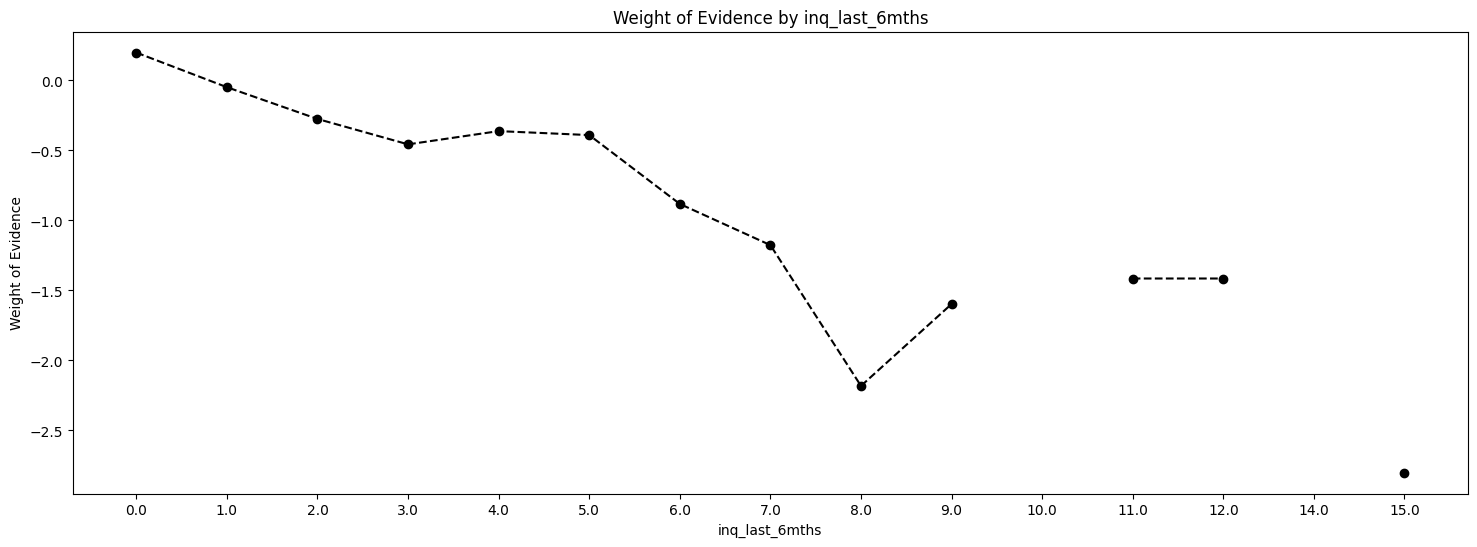

In [422]:
plot_by_woe(df_temp)

In [423]:
df_inputs_prepr['inq_last_6mths:0'] = np.where((df_inputs_prepr['inq_last_6mths'] == 0), 1, 0)
df_inputs_prepr['inq_last_6mths:1-2'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 1) & (df_inputs_prepr['inq_last_6mths'] <= 2), 1, 0)
df_inputs_prepr['inq_last_6mths:3-6'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 3) & (df_inputs_prepr['inq_last_6mths'] <= 6), 1, 0)
df_inputs_prepr['inq_last_6mths:>6'] = np.where((df_inputs_prepr['inq_last_6mths'] > 6), 1, 0)

In [424]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'open_acc', df_targets_prepr)
df_temp

open_acc  n_obs  prop_good  prop_n_obs  n_good   n_bad  prop_n_good  \
0        0.0      7   0.714286    0.000075     5.0     2.0     0.000060   
1        1.0     26   0.884615    0.000279    23.0     3.0     0.000277   
2        2.0    359   0.824513    0.003850   296.0    63.0     0.003560   
3        3.0   1033   0.869313    0.011077   898.0   135.0     0.010799   
4        4.0   2562   0.885636    0.027472  2269.0   293.0     0.027287   
5        5.0   4288   0.890858    0.045980  3820.0   468.0     0.045939   
6        6.0   6222   0.886692    0.066719  5517.0   705.0     0.066348   
7        7.0   7492   0.890950    0.080337  6675.0   817.0     0.080274   
8        8.0   8474   0.893203    0.090867  7569.0   905.0     0.091025   
9        9.0   8922   0.886573    0.095671  7910.0  1012.0     0.095126   
10      10.0   8360   0.891029    0.089645  7449.0   911.0     0.089582   
11      11.0   7843   0.893536    0.084101  7008.0   835.0     0.084278   
12      12.0   6929   0.883966    0.074300  6125.0   804.0     0.073659   
13      13.0   5880   0.901020    0.063052  5298.0   582.0     0.063714   
14      14.0   5072   0.892942    0.054387  4529.0   543.0     0.054466   
15      15.0   4021   0.891321    0.043117  3584.0   437.0     0.043101   
16      16.0   3349   0.898179    0.035912  3008.0   341.0     0.036174   
17      17.0   2651   0.900415    0.028427  2387.0   264.0     0.028706   
18      18.0   2158   0.904078    0.023140  1951.0   207.0     0.023463   
19      19.0   1681   0.888757    0.018025  1494.0   187.0     0.017967   
20      20.0   1326   0.905732    0.014219  1201.0   125.0     0.014443   
21      21.0   1062   0.903955    0.011388   960.0   102.0     0.011545   
22      22.0    839   0.896305    0.008997   752.0    87.0     0.009044   
23      23.0    654   0.922018    0.007013   603.0    51.0     0.007252   
24      24.0    493   0.882353    0.005286   435.0    58.0     0.005231   
25      25.0    371   0.881402    0.003978   327.0    44.0     0.003933   
26      26.0    251   0.904382    0.002691   227.0    24.0     0.002730   
27      27.0    217   0.884793    0.002327   192.0    25.0     0.002309   
28      28.0    152   0.907895    0.001630   138.0    14.0     0.001660   
29      29.0    120   0.925000    0.001287   111.0     9.0     0.001335   
30      30.0     84   0.869048    0.000901    73.0    11.0     0.000878   
31      31.0     72   0.888889    0.000772    64.0     8.0     0.000770   
32      32.0     54   0.870370    0.000579    47.0     7.0     0.000565   
33      33.0     56   0.857143    0.000600    48.0     8.0     0.000577   
34      34.0     41   0.853659    0.000440    35.0     6.0     0.000421   
35      35.0     29   1.000000    0.000311    29.0     0.0     0.000349   
36      36.0     27   0.814815    0.000290    22.0     5.0     0.000265   
37      37.0     18   0.944444    0.000193    17.0     1.0     0.000204   
38      38.0     12   0.833333    0.000129    10.0     2.0     0.000120   
39      39.0     19   0.947368    0.000204    18.0     1.0     0.000216   
40      40.0      7   0.857143    0.000075     6.0     1.0     0.000072   
41      41.0      7   1.000000    0.000075     7.0     0.0     0.000084   
42      42.0      6   0.833333    0.000064     5.0     1.0     0.000060   
43      43.0      1   1.000000    0.000011     1.0     0.0     0.000012   
44      44.0      2   1.000000    0.000021     2.0     0.0     0.000024   
45      45.0      2   1.000000    0.000021     2.0     0.0     0.000024   
46      46.0      1   1.000000    0.000011     1.0     0.0     0.000012   
47      49.0      1   1.000000    0.000011     1.0     0.0     0.000012   
48      51.0      3   1.000000    0.000032     3.0     0.0     0.000036   
49      54.0      1   1.000000    0.000011     1.0     0.0     0.000012   

    prop_n_bad       WoE  diff_prop_good  diff_WoE   IV  
0     0.000198 -1.191460             NaN       NaN  inf  
1     0.000297 -0.070869        0.170330  1.120591  inf  
2   

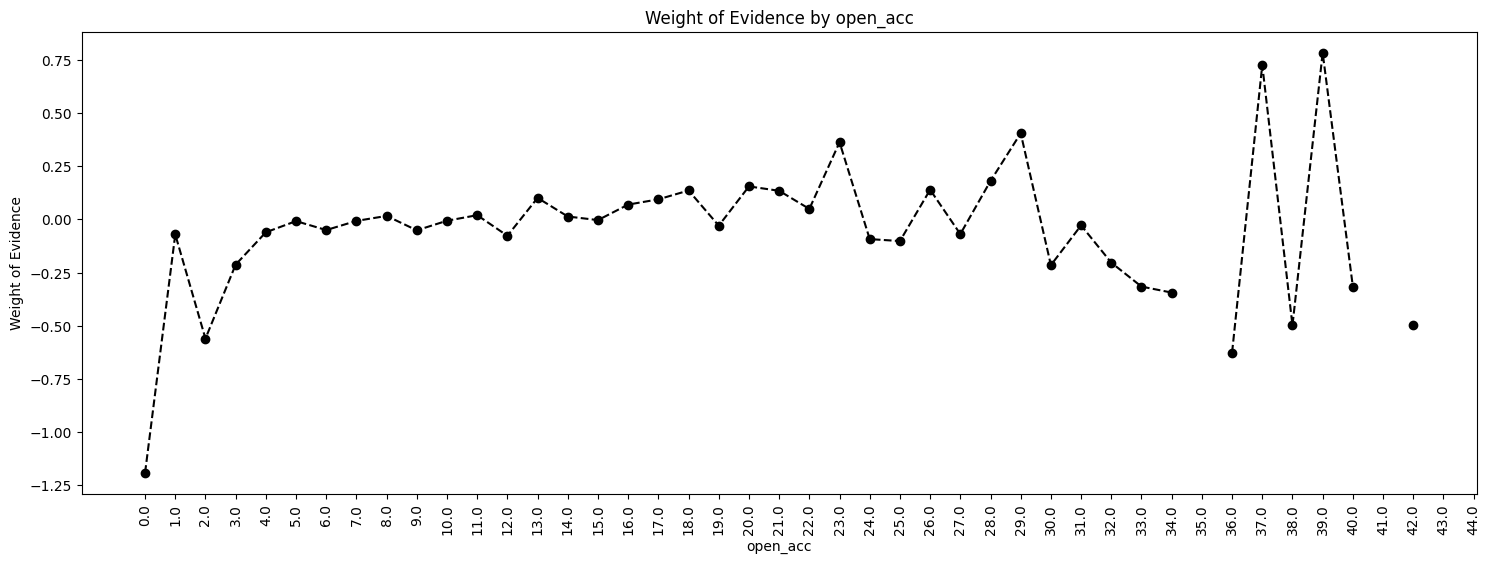

In [425]:
plot_by_woe(df_temp, 90)

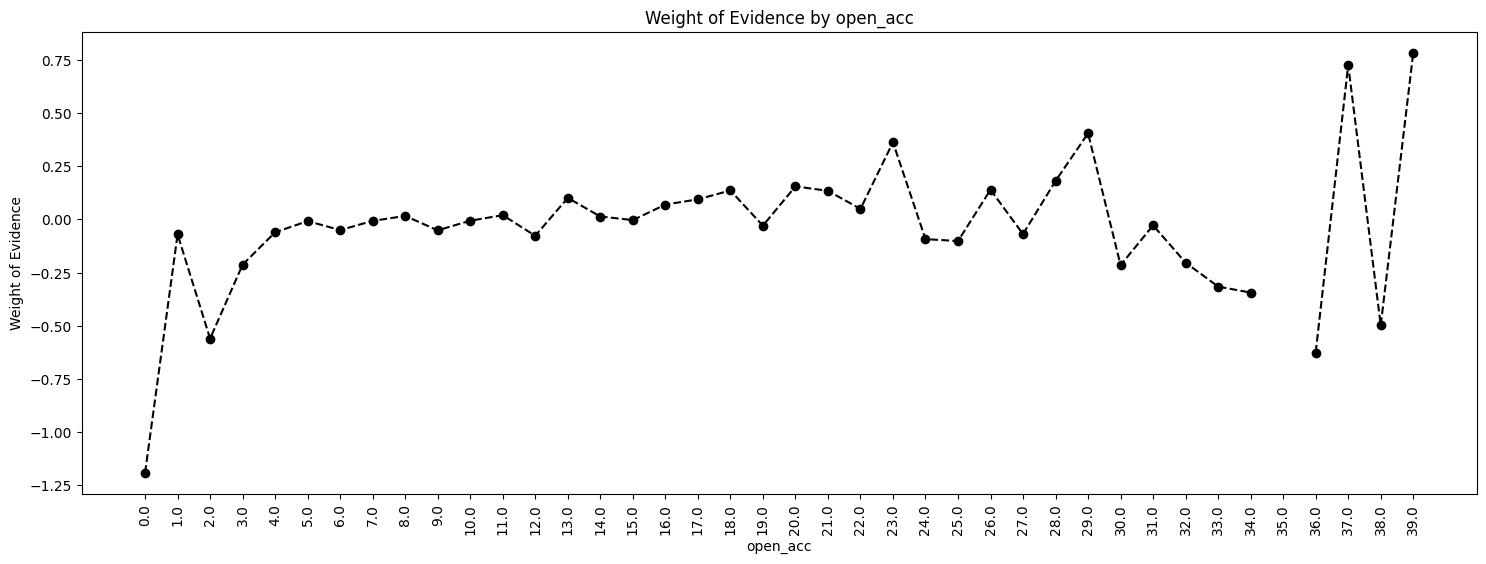

In [426]:
plot_by_woe(df_temp.iloc[ : 40, :], 90)

In [427]:
df_inputs_prepr['open_acc:0'] = np.where((df_inputs_prepr['open_acc'] == 0), 1, 0)
df_inputs_prepr['open_acc:1-3'] = np.where((df_inputs_prepr['open_acc'] >= 1) & (df_inputs_prepr['open_acc'] <= 3), 1, 0)
df_inputs_prepr['open_acc:4-12'] = np.where((df_inputs_prepr['open_acc'] >= 4) & (df_inputs_prepr['open_acc'] <= 12), 1, 0)
df_inputs_prepr['open_acc:13-17'] = np.where((df_inputs_prepr['open_acc'] >= 13) & (df_inputs_prepr['open_acc'] <= 17), 1, 0)
df_inputs_prepr['open_acc:18-22'] = np.where((df_inputs_prepr['open_acc'] >= 18) & (df_inputs_prepr['open_acc'] <= 22), 1, 0)
df_inputs_prepr['open_acc:23-25'] = np.where((df_inputs_prepr['open_acc'] >= 23) & (df_inputs_prepr['open_acc'] <= 25), 1, 0)
df_inputs_prepr['open_acc:26-30'] = np.where((df_inputs_prepr['open_acc'] >= 26) & (df_inputs_prepr['open_acc'] <= 30), 1, 0)
df_inputs_prepr['open_acc:>=31'] = np.where((df_inputs_prepr['open_acc'] >= 31), 1, 0)

In [428]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'pub_rec', df_targets_prepr)
df_temp

pub_rec  n_obs  prop_good  prop_n_obs   n_good   n_bad  prop_n_good  \
0       0.0  80874   0.891065    0.867216  72064.0  8810.0     0.866643   
1       1.0  10684   0.893954    0.114565   9551.0  1133.0     0.114861   
2       2.0   1136   0.899648    0.012181   1022.0   114.0     0.012291   
3       3.0    326   0.911043    0.003496    297.0    29.0     0.003572   
4       4.0    112   0.910714    0.001201    102.0    10.0     0.001227   
5       5.0     58   0.965517    0.000622     56.0     2.0     0.000673   
6       6.0     27   0.888889    0.000290     24.0     3.0     0.000289   
7       7.0     20   0.900000    0.000214     18.0     2.0     0.000216   
8       8.0      8   1.000000    0.000086      8.0     0.0     0.000096   
9       9.0      5   0.800000    0.000054      4.0     1.0     0.000048   
10     10.0      3   1.000000    0.000032      3.0     0.0     0.000036   
11     11.0      1   1.000000    0.000011      1.0     0.0     0.000012   
12     12.0      1   1.000000    0.000011      1.0     0.0     0.000012   
13     13.0      1   1.000000    0.000011      1.0     0.0     0.000012   
14     49.0      1   1.000000    0.000011      1.0     0.0     0.000012   

    prop_n_bad       WoE  diff_prop_good  diff_WoE   IV  
0     0.871932 -0.006084             NaN       NaN  inf  
1     0.112134  0.024026        0.002888  0.030110  inf  
2     0.011283  0.085567        0.005694  0.061541  inf  
3     0.002870  0.218685        0.011395  0.133118  inf  
4     0.000990  0.214637        0.000329  0.004049  inf  
5     0.000198  1.224454        0.054803  1.009817  inf  
6     0.000297 -0.028309        0.076628  1.252763  inf  
7     0.000198  0.089474        0.011111  0.117783  inf  
8     0.000000       inf        0.100000       inf  inf  
9     0.000099 -0.721457        0.200000       inf  inf  
10    0.000000       inf        0.200000       inf  inf  
11    0.000000       inf        0.000000       NaN  inf  
12    0.000000       inf        0.000000       NaN  inf  
13    0.000000       inf        0.000000       NaN  inf  
14    0.000000       inf        0.000000       NaN  inf

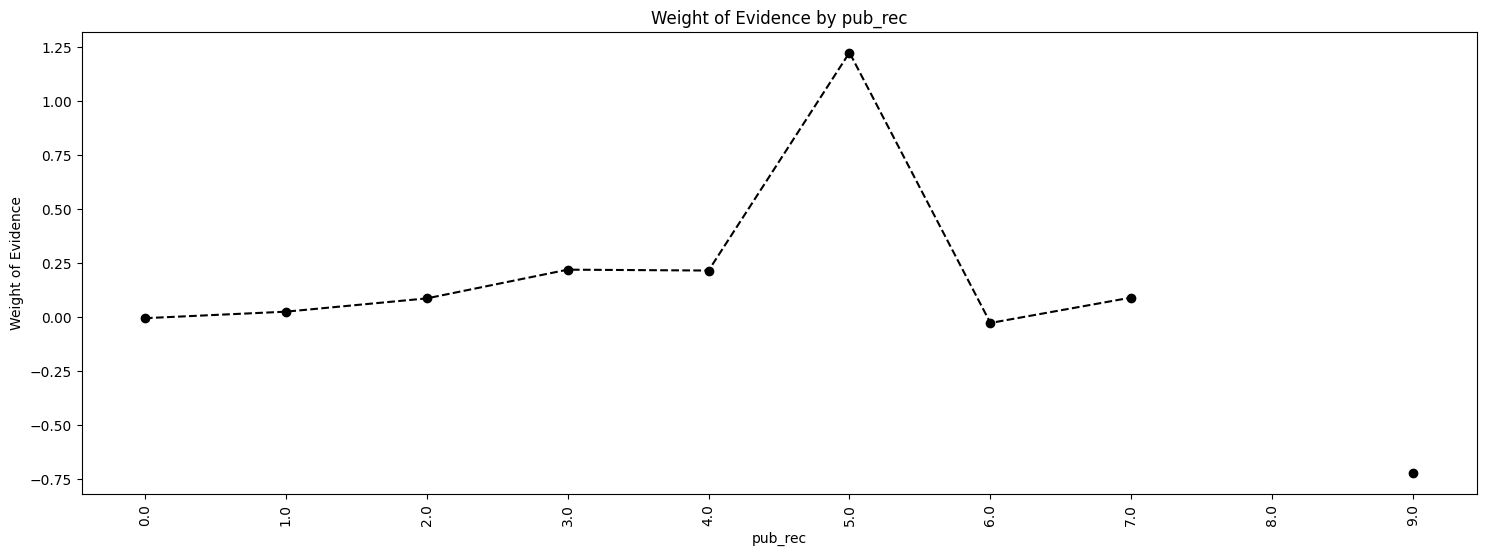

In [429]:
plot_by_woe(df_temp, 90)

In [430]:
df_inputs_prepr['pub_rec:0-2'] = np.where((df_inputs_prepr['pub_rec'] >= 0) & (df_inputs_prepr['pub_rec'] <= 2), 1, 0)
df_inputs_prepr['pub_rec:3-4'] = np.where((df_inputs_prepr['pub_rec'] >= 3) & (df_inputs_prepr['pub_rec'] <= 4), 1, 0)
df_inputs_prepr['pub_rec:>=5'] = np.where((df_inputs_prepr['pub_rec'] >= 5), 1, 0)

In [431]:
df_inputs_prepr['total_acc_factor'] = pd.cut(df_inputs_prepr['total_acc'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'total_acc_factor', df_targets_prepr)
df_temp

total_acc_factor  n_obs  prop_good  prop_n_obs  n_good   n_bad  \
0     (-0.106, 2.12]     21   0.761905    0.000225    16.0     5.0   
1       (2.12, 4.24]    409   0.831296    0.004386   340.0    69.0   
2       (4.24, 6.36]   1204   0.856312    0.012911  1031.0   173.0   
3       (6.36, 8.48]   2206   0.868087    0.023655  1915.0   291.0   
4       (8.48, 10.6]   3368   0.871437    0.036115  2935.0   433.0   
5      (10.6, 12.72]   4452   0.882749    0.047739  3930.0   522.0   
6     (12.72, 14.84]   5407   0.883484    0.057980  4777.0   630.0   
7     (14.84, 16.96]   6234   0.883061    0.066848  5505.0   729.0   
8     (16.96, 19.08]   9974   0.886304    0.106952  8840.0  1134.0   
9      (19.08, 21.2]   6814   0.892427    0.073067  6081.0   733.0   
10     (21.2, 23.32]   6740   0.893769    0.072273  6024.0   716.0   
11    (23.32, 25.44]   6275   0.893386    0.067287  5606.0   669.0   
12    (25.44, 27.56]   6067   0.899456    0.065057  5457.0   610.0   
13    (27.56, 29.68]   5436   0.896983    0.058291  4876.0   560.0   
14     (29.68, 31.8]   4799   0.898312    0.051460  4311.0   488.0   
15     (31.8, 33.92]   4150   0.899518    0.044501  3733.0   417.0   
16    (33.92, 36.04]   5070   0.903550    0.054366  4581.0   489.0   
17    (36.04, 38.16]   2797   0.908116    0.029992  2540.0   257.0   
18    (38.16, 40.28]   2336   0.894264    0.025049  2089.0   247.0   
19     (40.28, 42.4]   2004   0.901198    0.021489  1806.0   198.0   
20     (42.4, 44.52]   1601   0.905059    0.017168  1449.0   152.0   
21    (44.52, 46.64]   1231   0.890333    0.013200  1096.0   135.0   
22    (46.64, 48.76]   1041   0.898175    0.011163   935.0   106.0   
23    (48.76, 50.88]    797   0.912171    0.008546   727.0    70.0   
24     (50.88, 53.0]    905   0.909392    0.009704   823.0    82.0   
25     (53.0, 55.12]    438   0.913242    0.004697   400.0    38.0   
26    (55.12, 57.24]    339   0.911504    0.003635   309.0    30.0   
27    (57.24, 59.36]    261   0.881226    0.002799   230.0    31.0   
28    (59.36, 61.48]    223   0.887892    0.002391   198.0    25.0   
29     (61.48, 63.6]    416   0.899038    0.004461   374.0    42.0   
30     (63.6, 65.72]     55   0.963636    0.000590    53.0     2.0   
31    (65.72, 67.84]     40   0.850000    0.000429    34.0     6.0   
32    (67.84, 69.96]     42   0.904762    0.000450    38.0     4.0   
33    (69.96, 72.08]     25   1.000000    0.000268    25.0     0.0   
34     (72.08, 74.2]     14   1.000000    0.000150    14.0     0.0   
35     (74.2, 76.32]     14   0.857143    0.000150    12.0     2.0   
36    (76.32, 78.44]     14   0.714286    0.000150    10.0     4.0   
37    (78.44, 80.56]     11   0.818182    0.000118     9.0     2.0   
38    (80.56, 82.68]      6   0.833333    0.000064     5.0     1.0   
39     (82.68, 84.8]      5   1.000000    0.000054     5.0     0.0   
40     (84.8, 86.92]      3   1.000000    0.000032     3.0     0.0   
41    (86.92, 89.04]      4   1.000000    0.000043     4.0     0.0   
42    (89.04, 91.16]      5   0.800000    0.000054     4.0     1.0   
43    (91.16, 93.28]      2   0.500000    0.000021     1.0     1.0   
44     (93.28, 95.4]      0        NaN    0.000000     NaN     NaN   
45     (95.4, 97.52]      1   1.000000    0.000011     1.0     0.0   
46    (97.52, 99.64]      0        NaN    0.000000     NaN     NaN   
47   (99.64, 101.76]      0        NaN    0.000000     NaN     NaN   
48  (101.76, 103.88]      0        NaN    0.000000     NaN     NaN   
49   (103.88, 106.0]      1   1.000000    0.000011     1.0     0.0   

    prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE   IV  
0      0.000192    0.000495 -0.944600             NaN       NaN  inf  
1      0.004089    0.006829 -0.512912        0.069391  0.431688  inf  
2      0.012399    0.017122 -0.322758        0.025016  0.190154  inf  
3      0.023030    0.028800 -0.223601        0.011775  0.099157  inf  
4      0.035296    0.042854 -0.194026        0.003350  0.029575  inf  
5      

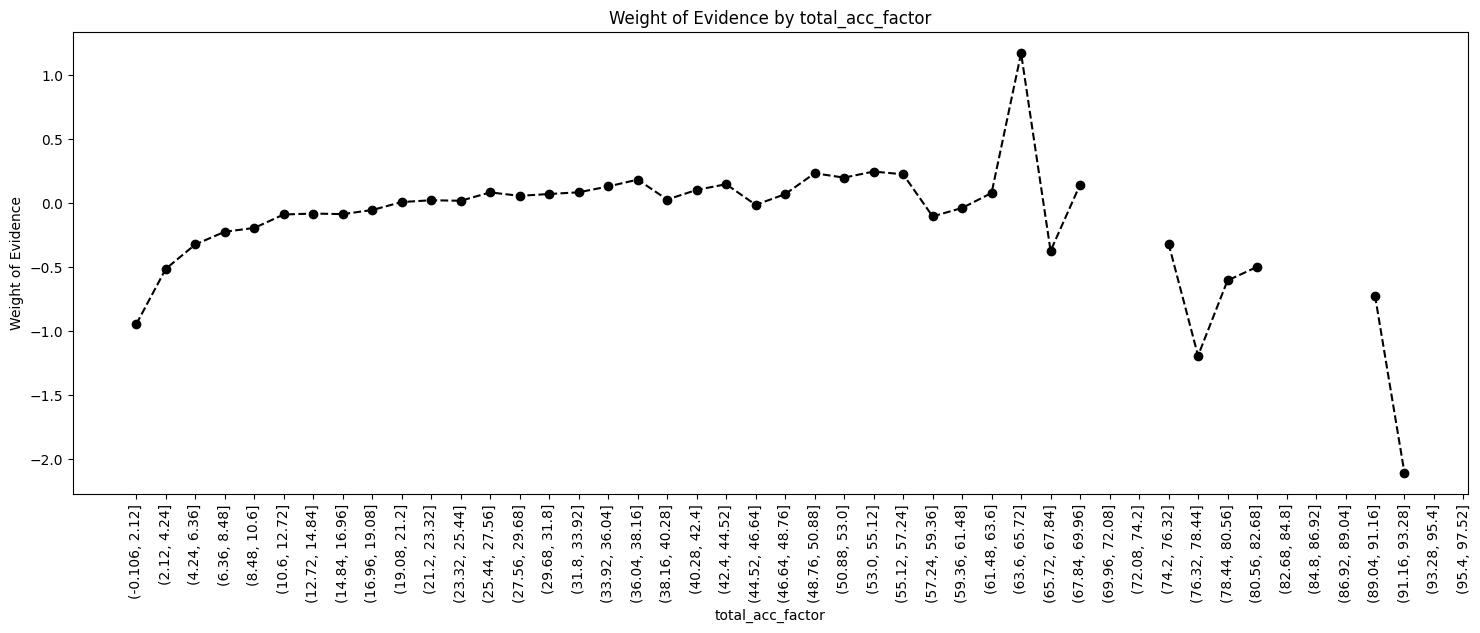

In [432]:
plot_by_woe(df_temp, 90)

In [433]:
df_inputs_prepr['total_acc:<=25'] = np.where((df_inputs_prepr['total_acc'] <= 25), 1, 0)
df_inputs_prepr['total_acc:25-51'] = np.where((df_inputs_prepr['total_acc'] >= 25) & (df_inputs_prepr['total_acc'] <= 51), 1, 0)
df_inputs_prepr['total_acc:>=51'] = np.where((df_inputs_prepr['total_acc'] >= 51), 1, 0)

In [434]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'acc_now_delinq', df_targets_prepr)
df_temp

acc_now_delinq  n_obs  prop_good  prop_n_obs   n_good    n_bad  \
0             0.0  92884   0.891650    0.996000  82820.0  10064.0   
1             1.0    351   0.894587    0.003764    314.0     37.0   
2             2.0     18   0.833333    0.000193     15.0      3.0   
3             3.0      2   1.000000    0.000021      2.0      0.0   
4             4.0      2   1.000000    0.000021      2.0      0.0   

   prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE   IV  
0     0.995995    0.996041 -0.000046             NaN       NaN  inf  
1     0.003776    0.003662  0.030724        0.002937  0.030770  inf  
2     0.000180    0.000297 -0.498313        0.061254  0.529037  inf  
3     0.000024    0.000000       inf        0.166667       inf  inf  
4     0.000024    0.000000       inf        0.000000       NaN  inf

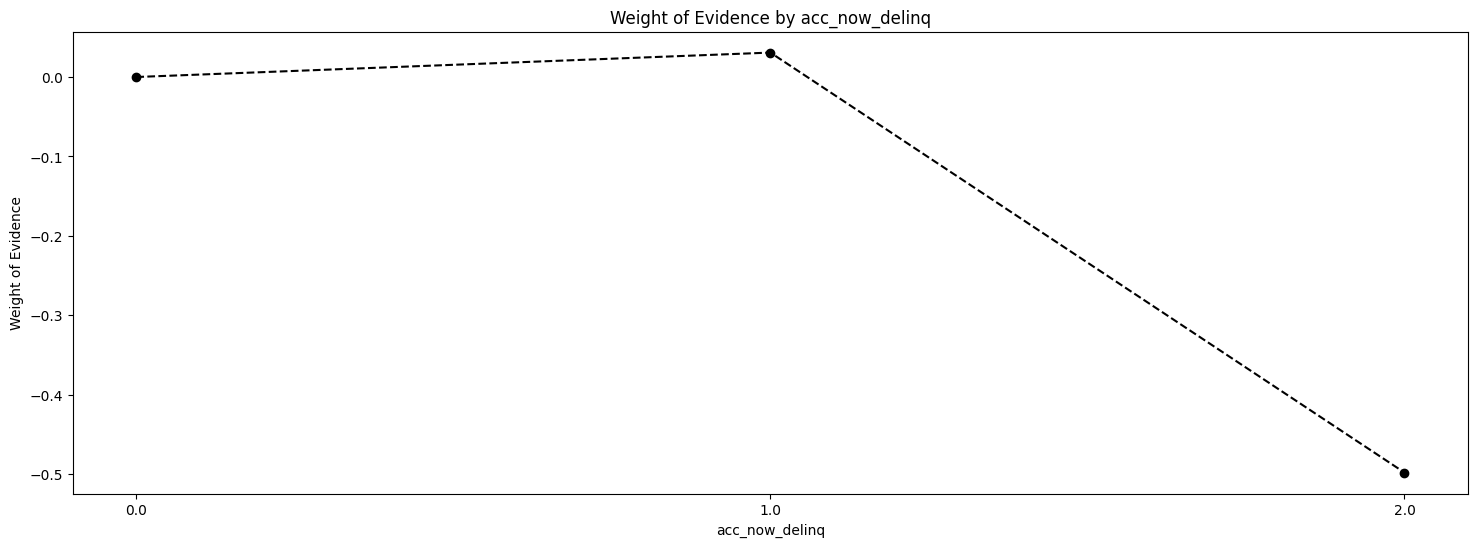

In [435]:
plot_by_woe(df_temp)

In [436]:
df_inputs_prepr['acc_now_delinq:0'] = np.where((df_inputs_prepr['acc_now_delinq'] == 0), 1, 0)
df_inputs_prepr['acc_now_delinq:>=1'] = np.where((df_inputs_prepr['acc_now_delinq'] >= 1), 1, 0)

In [437]:
df_inputs_prepr['total_rev_hi_lim_factor'] = pd.cut(df_inputs_prepr['total_rev_hi_lim'], 2000)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'total_rev_hi_lim_factor', df_targets_prepr)
df_temp

C:\WPy64-31101\python-3.11.0.amd64\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


total_rev_hi_lim_factor  n_obs  prop_good  prop_n_obs  n_good  n_bad  \
0            (-867.0, 433.5]     45   0.866667    0.000483    39.0    6.0   
1             (433.5, 867.0]     48   0.916667    0.000515    44.0    4.0   
2            (867.0, 1300.5]    248   0.822581    0.002659   204.0   44.0   
3           (1300.5, 1734.0]    243   0.827160    0.002606   201.0   42.0   
4           (1734.0, 2167.5]    376   0.853723    0.004032   321.0   55.0   
5           (2167.5, 2601.0]    463   0.868251    0.004965   402.0   61.0   
6           (2601.0, 3034.5]    595   0.836975    0.006380   498.0   97.0   
7           (3034.5, 3468.0]    352   0.889205    0.003775   313.0   39.0   
8           (3468.0, 3901.5]    614   0.842020    0.006584   517.0   97.0   
9           (3901.5, 4335.0]    878   0.881549    0.009415   774.0  104.0   
10          (4335.0, 4768.5]    615   0.873171    0.006595   537.0   78.0   
11          (4768.5, 5202.0]   1438   0.846314    0.015420  1217.0  221.0   
12          (5202.0, 5635.5]    791   0.874842    0.008482   692.0   99.0   
13          (5635.5, 6069.0]   1279   0.871775    0.013715  1115.0  164.0   
14          (6069.0, 6502.5]   1080   0.880556    0.011581   951.0  129.0   
15          (6502.5, 6936.0]    772   0.863990    0.008278   667.0  105.0   
16          (6936.0, 7369.5]   1233   0.888078    0.013222  1095.0  138.0   
17          (7369.5, 7803.0]   1197   0.885547    0.012835  1060.0  137.0   
18          (7803.0, 8236.5]   1359   0.870493    0.014573  1183.0  176.0   
19          (8236.5, 8670.0]    994   0.890342    0.010659   885.0  109.0   
20          (8670.0, 9103.5]   1291   0.871418    0.013843  1125.0  166.0   
21          (9103.5, 9537.0]   1016   0.886811    0.010895   901.0  115.0   
22          (9537.0, 9970.5]   1060   0.867925    0.011366   920.0  140.0   
23         (9970.5, 10404.0]   2135   0.866511    0.022894  1850.0  285.0   
24        (10404.0, 10837.5]   1067   0.865979    0.011442   924.0  143.0   
25        (10837.5, 11271.0]   1125   0.877333    0.012063   987.0  138.0   
26        (11271.0, 11704.5]   1232   0.883929    0.013211  1089.0  143.0   
27        (11704.5, 12138.0]   1760   0.872159    0.018873  1535.0  225.0   
28        (12138.0, 12571.5]   1077   0.888579    0.011549   957.0  120.0   
29        (12571.5, 13005.0]   1367   0.886613    0.014658  1212.0  155.0   
30        (13005.0, 13438.5]    951   0.882229    0.010198   839.0  112.0   
31        (13438.5, 13872.0]   1032   0.884690    0.011066   913.0  119.0   
32        (13872.0, 14305.5]   1413   0.878981    0.015152  1242.0  171.0   
33        (14305.5, 14739.0]   1099   0.890810    0.011785   979.0  120.0   
34        (14739.0, 15172.5]   1613   0.874768    0.017296  1411.0  202.0   
35        (15172.5, 15606.0]   1169   0.869974    0.012535  1017.0  152.0   
36        (15606.0, 16039.5]   1283   0.875292    0.013758  1123.0  160.0   
37        (16039.5, 16473.0]    904   0.866150    0.009694   783.0  121.0   
38        (16473.0, 16906.5]   1200   0.886667    0.012868  1064.0  136.0   
39        (16906.5, 17340.0]   1001   0.871129    0.010734   872.0  129.0   
40        (17340.0, 17773.5]    925   0.890811    0.009919   824.0  101.0   
41        (17773.5, 18207.0]   1371   0.859956    0.014701  1179.0  192.0   
42        (18207.0, 18640.5]    944   0.868644    0.010123   820.0  124.0   
43        (18640.5, 19074.0]    877   0.879133    0.009404   771.0  106.0   
44        (19074.0, 19507.5]   1139   0.894644    0.012214  1019.0  120.0   
45        (19507.5, 19941.0]    826   0.883777    0.008857   730.0   96.0   
46        (19941.0, 20374.5]   1461   0.880903    0.015666  1287.0  174.0   
47        (20374.5, 20808.0]   1032   0.894380    0.011066   923.0  109.0   
48        (20808.0, 21241.5]    878   0.907745    0.009415   797.0   81.0   
49        (21241.5, 21675.0]    774   0.909561    0.008300   704.0   70.0   
50        (21675.0, 22108.5]   1039   0.886429    0.011141   921.0  118.0   
5

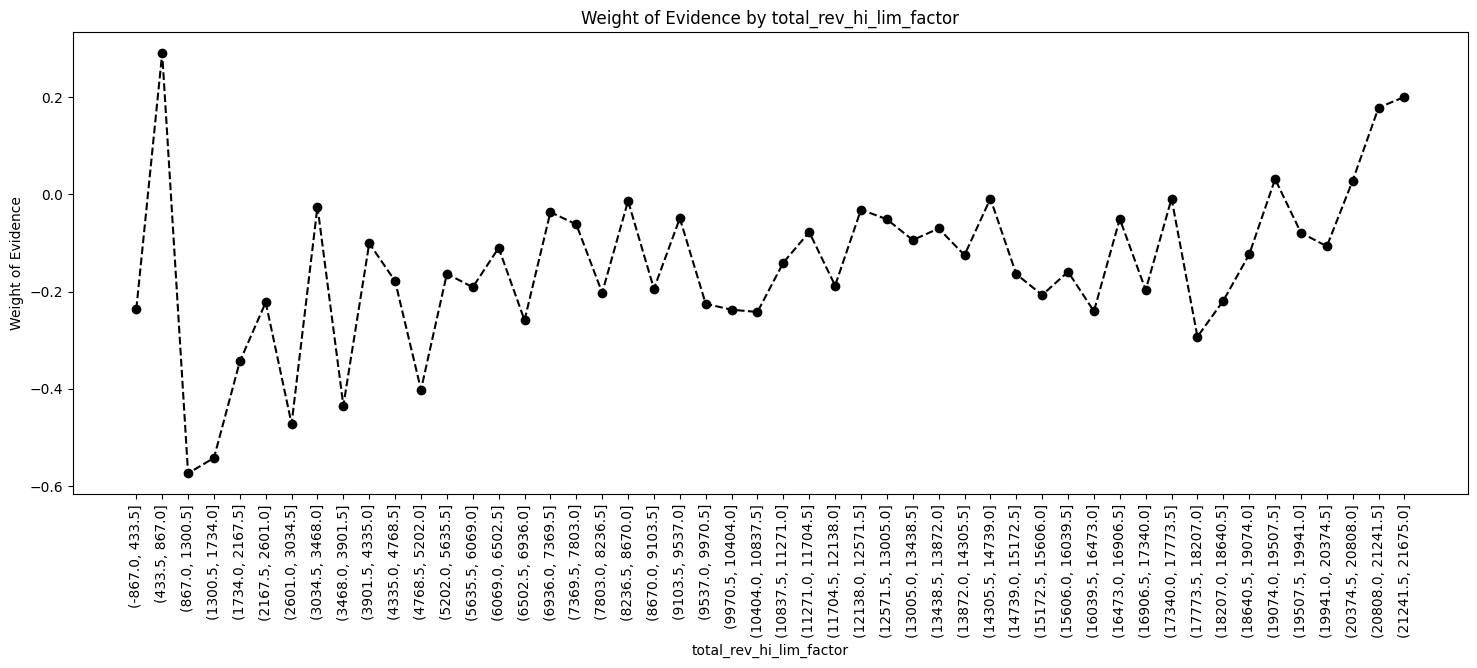

In [438]:
plot_by_woe(df_temp.iloc[: 50, :], 90)

In [439]:
df_inputs_prepr['total_rev_hi_lim:<=5K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] <= 5000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:5K-10K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 5000) & (df_inputs_prepr['total_rev_hi_lim'] <= 10000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:10K-20K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 10000) & (df_inputs_prepr['total_rev_hi_lim'] <= 20000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:20K-30K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 20000) & (df_inputs_prepr['total_rev_hi_lim'] <= 30000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:30K-40K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 30000) & (df_inputs_prepr['total_rev_hi_lim'] <= 40000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:40K-55K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 40000) & (df_inputs_prepr['total_rev_hi_lim'] <= 55000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:55K-95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 55000) & (df_inputs_prepr['total_rev_hi_lim'] <= 95000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:>95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 95000), 1, 0)

### Continuous variable processing (part 2):


In [440]:
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 110)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'annual_inc_factor', df_targets_prepr)
df_temp

annual_inc_factor  n_obs  prop_good  prop_n_obs   n_good  \
0          (-3496.0, 72145.455]  57318   0.876845    0.614624  50259.0   
1       (72145.455, 140290.909]  30463   0.912484    0.326656  27797.0   
2      (140290.909, 208436.364]   4020   0.926368    0.043107   3724.0   
3      (208436.364, 276581.818]    880   0.940909    0.009436    828.0   
4      (276581.818, 344727.273]    288   0.934028    0.003088    269.0   
5      (344727.273, 412872.727]    127   0.944882    0.001362    120.0   
6      (412872.727, 481018.182]     41   0.975610    0.000440     40.0   
7      (481018.182, 549163.636]     36   0.972222    0.000386     35.0   
8      (549163.636, 617309.091]     27   1.000000    0.000290     27.0   
9      (617309.091, 685454.545]      6   0.833333    0.000064      5.0   
10       (685454.545, 753600.0]     16   1.000000    0.000172     16.0   
11       (753600.0, 821745.455]      2   0.500000    0.000021      1.0   
12     (821745.455, 889890.909]      5   1.000000    0.000054      5.0   
13     (889890.909, 958036.364]      8   0.875000    0.000086      7.0   
14    (958036.364, 1026181.818]      2   1.000000    0.000021      2.0   
15   (1026181.818, 1094327.273]      3   1.000000    0.000032      3.0   
16   (1094327.273, 1162472.727]      3   1.000000    0.000032      3.0   
17   (1162472.727, 1230618.182]      3   1.000000    0.000032      3.0   
18   (1230618.182, 1298763.636]      2   1.000000    0.000021      2.0   
19   (1298763.636, 1366909.091]      1   1.000000    0.000011      1.0   
20   (1366909.091, 1435054.545]      0        NaN    0.000000      NaN   
21     (1435054.545, 1503200.0]      0        NaN    0.000000      NaN   
22     (1503200.0, 1571345.455]      1   1.000000    0.000011      1.0   
23   (1571345.455, 1639490.909]      1   1.000000    0.000011      1.0   
24   (1639490.909, 1707636.364]      0        NaN    0.000000      NaN   
25   (1707636.364, 1775781.818]      0        NaN    0.000000      NaN   
26   (1775781.818, 1843927.273]      0        NaN    0.000000      NaN   
27   (1843927.273, 1912072.727]      0        NaN    0.000000      NaN   
28   (1912072.727, 1980218.182]      0        NaN    0.000000      NaN   
29   (1980218.182, 2048363.636]      1   1.000000    0.000011      1.0   
30   (2048363.636, 2116509.091]      0        NaN    0.000000      NaN   
31   (2116509.091, 2184654.545]      0        NaN    0.000000      NaN   
32     (2184654.545, 2252800.0]      0        NaN    0.000000      NaN   
33     (2252800.0, 2320945.455]      0        NaN    0.000000      NaN   
34   (2320945.455, 2389090.909]      0        NaN    0.000000      NaN   
35   (2389090.909, 2457236.364]      0        NaN    0.000000      NaN   
36   (2457236.364, 2525381.818]      0        NaN    0.000000      NaN   
37   (2525381.818, 2593527.273]      0        NaN    0.000000      NaN   
38   (2593527.273, 2661672.727]      0        NaN    0.000000      NaN   
39   (2661672.727, 2729818.182]      0        NaN    0.000000      NaN   
40   (2729818.182, 2797963.636]      0        NaN    0.000000      NaN   
41   (2797963.636, 2866109.091]      0        NaN    0.000000      NaN   
42   (2866109.091, 2934254.545]      0        NaN    0.000000      NaN   
43     (2934254.545, 3002400.0]      0        NaN    0.000000      NaN   
44     (3002400.0, 3070545.455]      0        NaN    0.000000      NaN   
45   (3070545.455, 3138690.909]      0        NaN    0.000000      NaN   
46   (3138690.909, 3206836.364]      0        NaN    0.000000      NaN   
47   (3206836.364, 3274981.818]      0        NaN    0.000000      NaN   
48   (3274981.818, 3343127.273]      0        NaN    0.000000      NaN   
49   (3343127.273, 3411272.727]      0        NaN    0.000000      NaN   
50   (3411272.727, 3479418.182]      0        NaN    0.000000      NaN   
51   (3479418.182, 3547563.636]      0        NaN    0.000000      NaN   
52   (3547563.636, 3615709.091]      0        NaN    0.000000      NaN   
53   (3615709.091,

In [441]:
# we weill select annual_inc > 140k as a single category
# and preprocess lower income categories seperately
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['annual_inc'] <= 140000, :]

In [442]:
df_inputs_prepr_temp['annual_inc_factor'] = pd.cut(df_inputs_prepr_temp['annual_inc'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'annual_inc_factor', df_targets_prepr[df_inputs_prepr_temp.index])
df_temp

C:\Users\User\AppData\Local\Temp\ipykernel_4628\25049378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['annual_inc_factor'] = pd.cut(df_inputs_prepr_temp['annual_inc'], 50)


annual_inc_factor  n_obs  prop_good  prop_n_obs  n_good  n_bad  \
0       (3864.0, 6720.0]      6   0.833333    0.000068     5.0    1.0   
1       (6720.0, 9440.0]     37   0.918919    0.000422    34.0    3.0   
2      (9440.0, 12160.0]    149   0.785235    0.001697   117.0   32.0   
3     (12160.0, 14880.0]    195   0.769231    0.002221   150.0   45.0   
4     (14880.0, 17600.0]    350   0.828571    0.003987   290.0   60.0   
5     (17600.0, 20320.0]    727   0.848693    0.008282   617.0  110.0   
6     (20320.0, 23040.0]    736   0.843750    0.008385   621.0  115.0   
7     (23040.0, 25760.0]   1408   0.854403    0.016040  1203.0  205.0   
8     (25760.0, 28480.0]   1380   0.863768    0.015721  1192.0  188.0   
9     (28480.0, 31200.0]   2611   0.859824    0.029744  2245.0  366.0   
10    (31200.0, 33920.0]   1739   0.851639    0.019811  1481.0  258.0   
11    (33920.0, 36640.0]   3397   0.859288    0.038699  2919.0  478.0   
12    (36640.0, 39360.0]   2253   0.877497    0.025666  1977.0  276.0   
13    (39360.0, 42080.0]   4992   0.868189    0.056869  4334.0  658.0   
14    (42080.0, 44800.0]   1920   0.877604    0.021873  1685.0  235.0   
15    (44800.0, 47520.0]   4115   0.875334    0.046878  3602.0  513.0   
16    (47520.0, 50240.0]   5517   0.878376    0.062850  4846.0  671.0   
17    (50240.0, 52960.0]   2453   0.892377    0.027945  2189.0  264.0   
18    (52960.0, 55680.0]   4096   0.881836    0.046662  3612.0  484.0   
19    (55680.0, 58400.0]   2533   0.894197    0.028856  2265.0  268.0   
20    (58400.0, 61120.0]   4701   0.880664    0.053554  4140.0  561.0   
21    (61120.0, 63840.0]   1938   0.904541    0.022078  1753.0  185.0   
22    (63840.0, 66560.0]   3883   0.886170    0.044235  3441.0  442.0   
23    (66560.0, 69280.0]   1930   0.906736    0.021987  1750.0  180.0   
24    (69280.0, 72000.0]   4231   0.891988    0.048199  3774.0  457.0   
25    (72000.0, 74720.0]   1146   0.902269    0.013055  1034.0  112.0   
26    (74720.0, 77440.0]   3215   0.899222    0.036625  2891.0  324.0   
27    (77440.0, 80160.0]   3502   0.898915    0.039895  3148.0  354.0   
28    (80160.0, 82880.0]   1056   0.921402    0.012030   973.0   83.0   
29    (82880.0, 85600.0]   2589   0.910776    0.029494  2358.0  231.0   
30    (85600.0, 88320.0]   1208   0.916391    0.013762  1107.0  101.0   
31    (88320.0, 91040.0]   2396   0.899833    0.027295  2156.0  240.0   
32    (91040.0, 93760.0]    985   0.911675    0.011221   898.0   87.0   
33    (93760.0, 96480.0]   1711   0.909994    0.019492  1557.0  154.0   
34    (96480.0, 99200.0]    932   0.920601    0.010617   858.0   74.0   
35   (99200.0, 101920.0]   1958   0.910112    0.022306  1782.0  176.0   
36  (101920.0, 104640.0]    783   0.906769    0.008920   710.0   73.0   
37  (104640.0, 107360.0]   1070   0.917757    0.012189   982.0   88.0   
38  (107360.0, 110080.0]   1601   0.924422    0.018239  1480.0  121.0   
39  (110080.0, 112800.0]    327   0.920489    0.003725   301.0   26.0   
40  (112800.0, 115520.0]    821   0.943971    0.009353   775.0   46.0   
41  (115520.0, 118240.0]    404   0.923267    0.004602   373.0   31.0   
42  (118240.0, 120960.0]   1383   0.915401    0.015755  1266.0  117.0   
43  (120960.0, 123680.0]    271   0.955720    0.003087   259.0   12.0   
44  (123680.0, 126400.0]    842   0.933492    0.009592   786.0   56.0   
45  (126400.0, 129120.0]    256   0.925781    0.002916   237.0   19.0   
46  (129120.0, 131840.0]    696   0.928161    0.007929   646.0   50.0   
47  (131840.0, 134560.0]    202   0.905941    0.002301   183.0   19.0   
48  (134560.0, 137280.0]    490   0.938776    0.005582   460.0   30.0   
49  (137280.0, 140000.0]    640   0.928125    0.007291   594.0   46.0   

    prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE       IV  
0      0.000064    0.000103 -0.473289             NaN       NaN  0.05514  
1      0.000436    0.000308  0.345022        0.085586  0.818310  0.05514  
2      0.001499    0.003290 -0.786289        0.133684  1.1

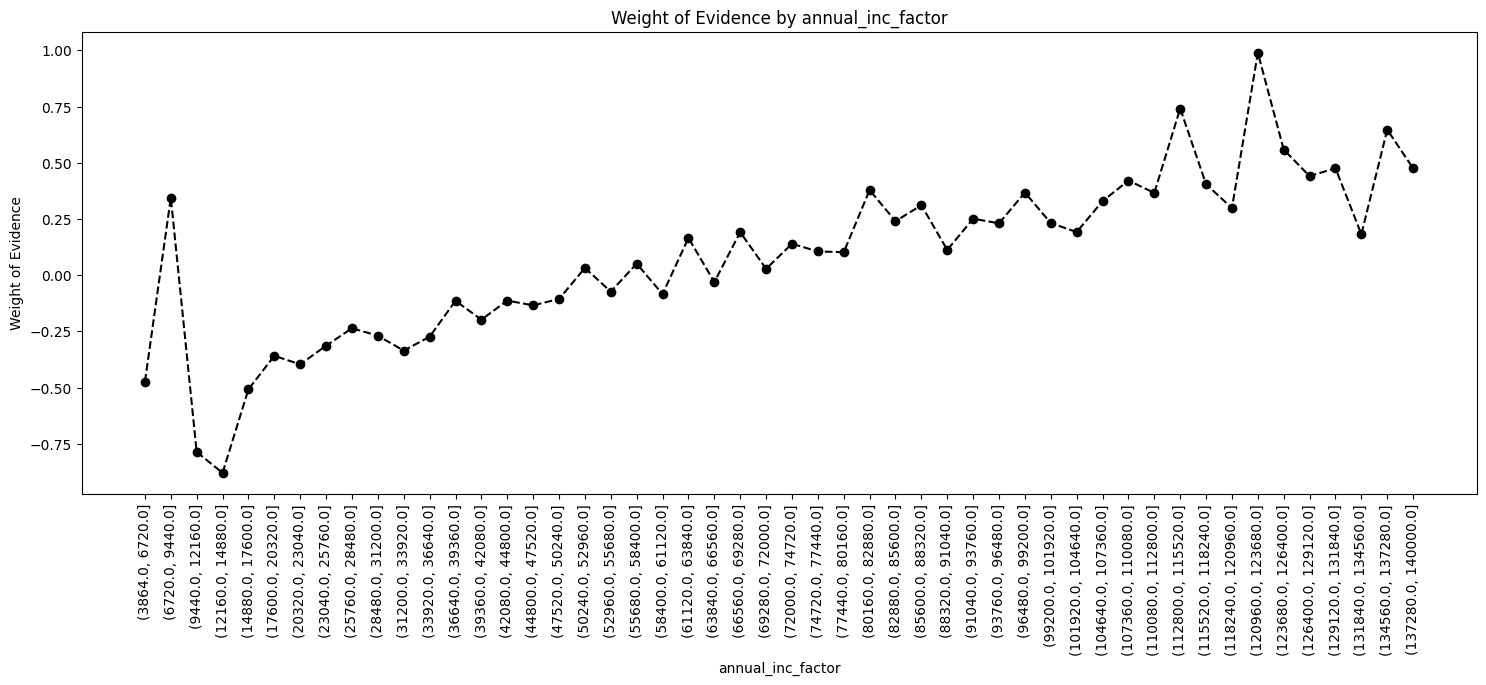

In [443]:
plot_by_woe(df_temp, 90)

In [444]:
df_inputs_prepr['annual_inc:<20K'] = np.where((df_inputs_prepr['annual_inc'] <= 20000), 1, 0)
df_inputs_prepr['annual_inc:20K-30K'] = np.where((df_inputs_prepr['annual_inc'] > 20000) & (df_inputs_prepr['annual_inc'] <= 30000), 1, 0)
df_inputs_prepr['annual_inc:30K-40K'] = np.where((df_inputs_prepr['annual_inc'] > 30000) & (df_inputs_prepr['annual_inc'] <= 40000), 1, 0)
df_inputs_prepr['annual_inc:40K-50K'] = np.where((df_inputs_prepr['annual_inc'] > 40000) & (df_inputs_prepr['annual_inc'] <= 50000), 1, 0)
df_inputs_prepr['annual_inc:50K-60K'] = np.where((df_inputs_prepr['annual_inc'] > 50000) & (df_inputs_prepr['annual_inc'] <= 60000), 1, 0)
df_inputs_prepr['annual_inc:60K-70K'] = np.where((df_inputs_prepr['annual_inc'] > 60000) & (df_inputs_prepr['annual_inc'] <= 70000), 1, 0)
df_inputs_prepr['annual_inc:70K-80K'] = np.where((df_inputs_prepr['annual_inc'] > 70000) & (df_inputs_prepr['annual_inc'] <= 80000), 1, 0)
df_inputs_prepr['annual_inc:80K-90K'] = np.where((df_inputs_prepr['annual_inc'] > 80000) & (df_inputs_prepr['annual_inc'] <= 90000), 1, 0)
df_inputs_prepr['annual_inc:90K-100K'] = np.where((df_inputs_prepr['annual_inc'] > 90000) & (df_inputs_prepr['annual_inc'] <= 100000), 1, 0)
df_inputs_prepr['annual_inc:100K-120K'] = np.where((df_inputs_prepr['annual_inc'] > 100000) & (df_inputs_prepr['annual_inc'] <= 120000), 1, 0)
df_inputs_prepr['annual_inc:120K-140K'] = np.where((df_inputs_prepr['annual_inc'] > 120000) & (df_inputs_prepr['annual_inc'] <= 140000), 1, 0)
df_inputs_prepr['annual_inc:>140K'] = np.where((df_inputs_prepr['annual_inc'] > 140000), 1, 0)

In [445]:
# mths_since_last_delinq
# create dummy where missing = 1
# not missing = 0
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_delinq'])]
df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_delinq_factor', df_targets_prepr[df_inputs_prepr_temp.index])
df_temp

C:\Users\User\AppData\Local\Temp\ipykernel_4628\3579597613.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)


mths_since_last_delinq_factor  n_obs  prop_good  prop_n_obs  n_good  n_bad  \
0                 (-0.148, 2.96]    933   0.855305    0.021613   798.0  135.0   
1                   (2.96, 5.92]   1604   0.887157    0.037156  1423.0  181.0   
2                   (5.92, 8.88]   2434   0.880444    0.056383  2143.0  291.0   
3                  (8.88, 11.84]   2535   0.899408    0.058723  2280.0  255.0   
4                  (11.84, 14.8]   2488   0.889871    0.057634  2214.0  274.0   
5                  (14.8, 17.76]   2316   0.892055    0.053650  2066.0  250.0   
6                 (17.76, 20.72]   2307   0.903771    0.053441  2085.0  222.0   
7                 (20.72, 23.68]   2058   0.887269    0.047673  1826.0  232.0   
8                 (23.68, 26.64]   2067   0.889211    0.047882  1838.0  229.0   
9                  (26.64, 29.6]   2002   0.905095    0.046376  1812.0  190.0   
10                 (29.6, 32.56]   1843   0.896907    0.042693  1653.0  190.0   
11                (32.56, 35.52]   1916   0.902923    0.044384  1730.0  186.0   
12                (35.52, 38.48]   1851   0.895192    0.042878  1657.0  194.0   
13                (38.48, 41.44]   1746   0.897480    0.040446  1567.0  179.0   
14                 (41.44, 44.4]   1748   0.885011    0.040492  1547.0  201.0   
15                 (44.4, 47.36]   1623   0.910043    0.037596  1477.0  146.0   
16                (47.36, 50.32]   1359   0.899191    0.031481  1222.0  137.0   
17                (50.32, 53.28]   1137   0.889182    0.026338  1011.0  126.0   
18                (53.28, 56.24]   1142   0.915061    0.026454  1045.0   97.0   
19                 (56.24, 59.2]   1100   0.898182    0.025481   988.0  112.0   
20                 (59.2, 62.16]   1055   0.881517    0.024439   930.0  125.0   
21                (62.16, 65.12]    989   0.881699    0.022910   872.0  117.0   
22                (65.12, 68.08]    985   0.887310    0.022817   874.0  111.0   
23                (68.08, 71.04]    952   0.888655    0.022053   846.0  106.0   
24                 (71.04, 74.0]    917   0.878953    0.021242   806.0  111.0   
25                 (74.0, 76.96]    651   0.918587    0.015080   598.0   53.0   
26                (76.96, 79.92]    799   0.903630    0.018509   722.0   77.0   
27                (79.92, 82.88]    553   0.860759    0.012810   476.0   77.0   
28                (82.88, 85.84]     18   0.722222    0.000417    13.0    5.0   
29                 (85.84, 88.8]     10   0.900000    0.000232     9.0    1.0   
30                 (88.8, 91.76]      4   0.750000    0.000093     3.0    1.0   
31                (91.76, 94.72]      2   1.000000    0.000046     2.0    0.0   
32                (94.72, 97.68]      5   0.800000    0.000116     4.0    1.0   
33               (97.68, 100.64]      3   1.000000    0.000069     3.0    0.0   
34               (100.64, 103.6]      1   1.000000    0.000023     1.0    0.0   
35               (103.6, 106.56]      4   1.000000    0.000093     4.0    0.0   
36              (106.56, 109.52]      1   1.000000    0.000023     1.0    0.0   
37              (109.52, 112.48]      1   1.000000    0.000023     1.0    0.0   
38              (112.48, 115.44]      1   1.000000    0.000023     1.0    0.0   
39               (115.44, 118.4]      2   1.000000    0.000046     2.0    0.0   
40               (118.4, 121.36]      2   1.000000    0.000046     2.0    0.0   
41              (121.36, 124.32]      0        NaN    0.000000     NaN    NaN   
42              (124.32, 127.28]      0        NaN    0.000000     NaN    NaN   
43              (127.28, 130.24]      0        NaN    0.000000     NaN    NaN   
44               (130.24, 133.2]      0        NaN    0.000000     NaN    NaN   
45               (133.2, 136.16]      1   1.000000    0.000023     1.0    0.0   
46              (136.16, 139.12]      1   1.000000    0.000023     1.0    0.0   
47              (139.12, 142.08]      0        NaN    0.000000     NaN    NaN   
48              (142.08, 145.04]  

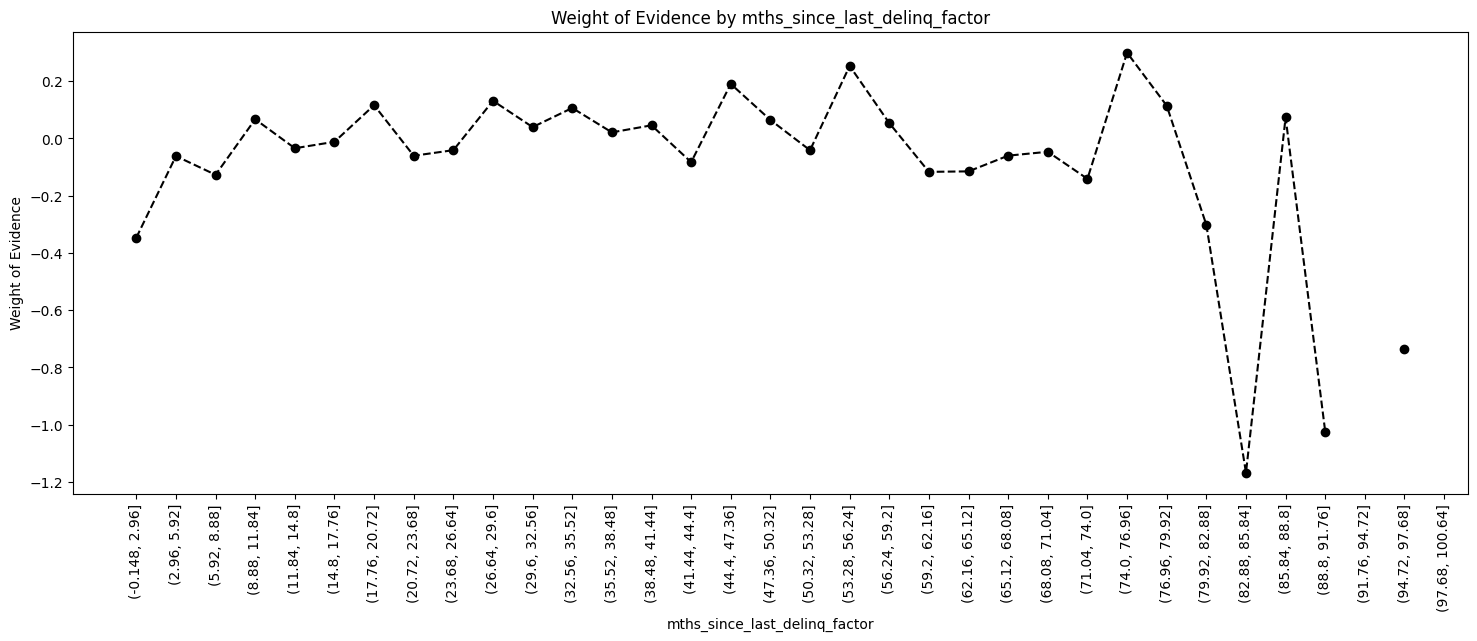

In [446]:
plot_by_woe(df_temp, 90)

In [447]:
df_inputs_prepr['mths_since_last_delinq:Missing'] = np.where((df_inputs_prepr['mths_since_last_delinq'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_delinq:0-3'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 0) & (df_inputs_prepr['mths_since_last_delinq'] < 4), 1, 0)
df_inputs_prepr['mths_since_last_delinq:4-30'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 4) & (df_inputs_prepr['mths_since_last_delinq'] < 31), 1, 0)
df_inputs_prepr['mths_since_last_delinq:31-56'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 31) & (df_inputs_prepr['mths_since_last_delinq'] < 57), 1, 0)
df_inputs_prepr['mths_since_last_delinq:>=57'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 57), 1, 0)

### additional continuous preprocessing
#### dti (debt to income ratio)
#### mths_since_last_record

In [448]:
df_inputs_prepr['dti'].unique()

array([ 8.58, 19.45, 25.03, ..., 35.35, 35.51, 36.82])

In [449]:
df_inputs_prepr['dti_factor'] = pd.cut(df_inputs_prepr['dti'], 100)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'dti_factor', df_targets_prepr)
df_temp

dti_factor  n_obs  prop_good  prop_n_obs  n_good  n_bad  \
0       (-0.04, 0.4]    186   0.876344    0.001994   163.0   23.0   
1         (0.4, 0.8]    196   0.954082    0.002102   187.0    9.0   
2       (0.8, 1.199]    220   0.909091    0.002359   200.0   20.0   
3     (1.199, 1.599]    237   0.890295    0.002541   211.0   26.0   
4     (1.599, 1.999]    312   0.913462    0.003346   285.0   27.0   
5     (1.999, 2.399]    330   0.924242    0.003539   305.0   25.0   
6     (2.399, 2.799]    372   0.927419    0.003989   345.0   27.0   
7     (2.799, 3.198]    442   0.909502    0.004740   402.0   40.0   
8     (3.198, 3.598]    474   0.913502    0.005083   433.0   41.0   
9     (3.598, 3.998]    573   0.919721    0.006144   527.0   46.0   
10    (3.998, 4.398]    596   0.909396    0.006391   542.0   54.0   
11    (4.398, 4.798]    636   0.918239    0.006820   584.0   52.0   
12    (4.798, 5.197]    688   0.906977    0.007377   624.0   64.0   
13    (5.197, 5.597]    765   0.909804    0.008203   696.0   69.0   
14    (5.597, 5.997]    817   0.931457    0.008761   761.0   56.0   
15    (5.997, 6.397]    915   0.899454    0.009812   823.0   92.0   
16    (6.397, 6.797]   1007   0.926514    0.010798   933.0   74.0   
17    (6.797, 7.196]    989   0.910010    0.010605   900.0   89.0   
18    (7.196, 7.596]   1061   0.915174    0.011377   971.0   90.0   
19    (7.596, 7.996]   1166   0.911664    0.012503  1063.0  103.0   
20    (7.996, 8.396]   1145   0.903057    0.012278  1034.0  111.0   
21    (8.396, 8.796]   1205   0.903734    0.012921  1089.0  116.0   
22    (8.796, 9.195]   1268   0.899842    0.013597  1141.0  127.0   
23    (9.195, 9.595]   1328   0.901355    0.014240  1197.0  131.0   
24    (9.595, 9.995]   1312   0.907774    0.014069  1191.0  121.0   
25   (9.995, 10.395]   1441   0.909091    0.015452  1310.0  131.0   
26  (10.395, 10.795]   1396   0.899713    0.014969  1256.0  140.0   
27  (10.795, 11.194]   1474   0.908412    0.015806  1339.0  135.0   
28  (11.194, 11.594]   1517   0.913645    0.016267  1386.0  131.0   
29  (11.594, 11.994]   1607   0.917237    0.017232  1474.0  133.0   
30  (11.994, 12.394]   1631   0.894543    0.017489  1459.0  172.0   
31  (12.394, 12.794]   1739   0.896492    0.018647  1559.0  180.0   
32  (12.794, 13.193]   1646   0.902187    0.017650  1485.0  161.0   
33  (13.193, 13.593]   1692   0.897754    0.018143  1519.0  173.0   
34  (13.593, 13.993]   1711   0.895383    0.018347  1532.0  179.0   
35  (13.993, 14.393]   1709   0.905793    0.018326  1548.0  161.0   
36  (14.393, 14.793]   1784   0.908072    0.019130  1620.0  164.0   
37  (14.793, 15.192]   1766   0.901472    0.018937  1592.0  174.0   
38  (15.192, 15.592]   1740   0.896552    0.018658  1560.0  180.0   
39  (15.592, 15.992]   1732   0.897806    0.018572  1555.0  177.0   
40  (15.992, 16.392]   1716   0.891026    0.018401  1529.0  187.0   
41  (16.392, 16.792]   1672   0.894139    0.017929  1495.0  177.0   
42  (16.792, 17.191]   1732   0.889723    0.018572  1541.0  191.0   
43  (17.191, 17.591]   1628   0.886364    0.017457  1443.0  185.0   
44  (17.591, 17.991]   1629   0.901780    0.017468  1469.0  160.0   
45  (17.991, 18.391]   1732   0.894919    0.018572  1550.0  182.0   
46  (18.391, 18.791]   1697   0.896288    0.018197  1521.0  176.0   
47   (18.791, 19.19]   1641   0.886654    0.017597  1455.0  186.0   
48    (19.19, 19.59]   1570   0.895541    0.016835  1406.0  164.0   
49    (19.59, 19.99]   1617   0.887446    0.017339  1435.0  182.0   
50    (19.99, 20.39]   1561   0.883408    0.016739  1379.0  182.0   
51    (20.39, 20.79]   1584   0.882576    0.016985  1398.0  186.0   
52   (20.79, 21.189]   1470   0.880272    0.015763  1294.0  176.0   
53  (21.189, 21.589]   1530   0.876471    0.016406  1341.0  189.0   
54  (21.589, 21.989]   1434   0.877964    0.015377  1259.0  175.0   
55  (21.989, 22.389]   1375   0.866909    0.014744  1192.0  183.0   
56  (22.389, 22.789]   1325   0.868679    0.014208  1151.0  174.0   
57  (22.

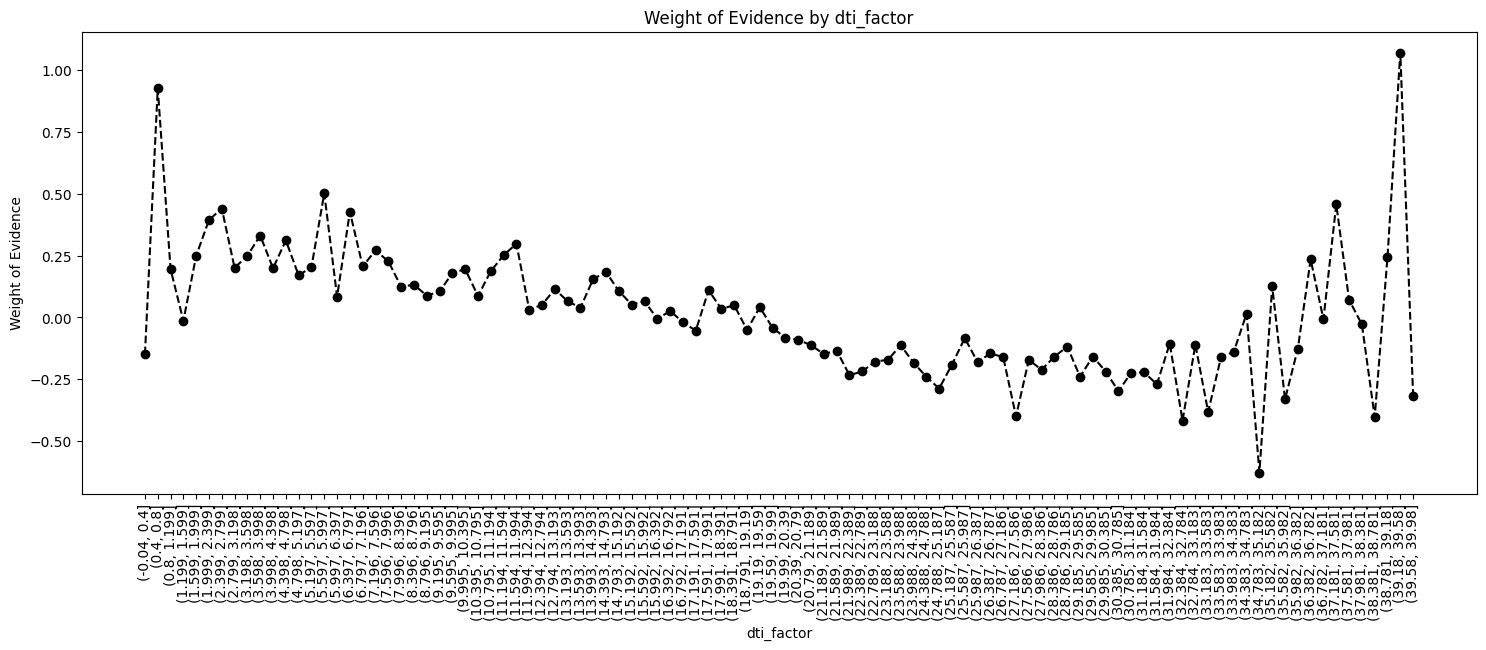

In [450]:
plot_by_woe(df_temp, 90)

In [451]:
# we will select dti > 35 in a single category
# and preprocess lower income categories seperately
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['dti'] <= 35, :]

In [452]:
df_inputs_prepr_temp['dti_factor'] = pd.cut(df_inputs_prepr_temp['dti'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'dti_factor', df_targets_prepr[df_inputs_prepr_temp.index])
df_temp

C:\Users\User\AppData\Local\Temp\ipykernel_4628\2843865280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['dti_factor'] = pd.cut(df_inputs_prepr_temp['dti'], 50)


dti_factor  n_obs  prop_good  prop_n_obs  n_good  n_bad  prop_n_good  \
0   (-0.035, 0.7]    330   0.912121    0.003565   301.0   29.0     0.003647   
1      (0.7, 1.4]    403   0.900744    0.004354   363.0   40.0     0.004398   
2      (1.4, 2.1]    503   0.918489    0.005434   462.0   41.0     0.005598   
3      (2.1, 2.8]    632   0.922468    0.006828   583.0   49.0     0.007064   
4      (2.8, 3.5]    784   0.915816    0.008470   718.0   66.0     0.008699   
5      (3.5, 4.2]    972   0.910494    0.010501   885.0   87.0     0.010723   
6      (4.2, 4.9]   1125   0.916444    0.012154  1031.0   94.0     0.012492   
7      (4.9, 5.6]   1298   0.909861    0.014023  1181.0  117.0     0.014309   
8      (5.6, 6.3]   1501   0.918055    0.016216  1378.0  123.0     0.016696   
9      (6.3, 7.0]   1705   0.914370    0.018419  1559.0  146.0     0.018889   
10     (7.0, 7.7]   1826   0.915115    0.019727  1671.0  155.0     0.020246   
11     (7.7, 8.4]   2048   0.906738    0.022125  1857.0  191.0     0.022500   
12     (8.4, 9.1]   2171   0.897743    0.023454  1949.0  222.0     0.023615   
13     (9.1, 9.8]   2301   0.910474    0.024858  2095.0  206.0     0.025383   
14    (9.8, 10.5]   2444   0.906301    0.026403  2215.0  229.0     0.026837   
15   (10.5, 11.2]   2541   0.902401    0.027451  2293.0  248.0     0.027782   
16   (11.2, 11.9]   2698   0.916976    0.029147  2474.0  224.0     0.029976   
17   (11.9, 12.6]   2958   0.894185    0.031956  2645.0  313.0     0.032047   
18   (12.6, 13.3]   2890   0.903806    0.031221  2612.0  278.0     0.031648   
19   (13.3, 14.0]   3011   0.894719    0.032528  2694.0  317.0     0.032641   
20   (14.0, 14.7]   3018   0.907223    0.032604  2738.0  280.0     0.033174   
21   (14.7, 15.4]   3063   0.903363    0.033090  2767.0  296.0     0.033526   
22   (15.4, 16.1]   3020   0.896358    0.032626  2707.0  313.0     0.032799   
23   (16.1, 16.8]   2971   0.890946    0.032096  2647.0  324.0     0.032072   
24   (16.8, 17.5]   3005   0.886855    0.032464  2665.0  340.0     0.032290   
25   (17.5, 18.2]   2910   0.899656    0.031437  2618.0  292.0     0.031720   
26   (18.2, 18.9]   2980   0.890940    0.032194  2655.0  325.0     0.032169   
27   (18.9, 19.6]   2734   0.895026    0.029536  2447.0  287.0     0.029648   
28   (19.6, 20.3]   2828   0.886139    0.030552  2506.0  322.0     0.030363   
29   (20.3, 21.0]   2763   0.880927    0.029849  2434.0  329.0     0.029491   
30   (21.0, 21.7]   2608   0.881135    0.028175  2298.0  310.0     0.027843   
31   (21.7, 22.4]   2427   0.868562    0.026219  2108.0  319.0     0.025541   
32   (22.4, 23.1]   2351   0.869843    0.025398  2045.0  306.0     0.024778   
33   (23.1, 23.8]   2286   0.876640    0.024696  2004.0  282.0     0.024281   
34   (23.8, 24.5]   2271   0.874064    0.024534  1985.0  286.0     0.024051   
35   (24.5, 25.2]   2008   0.862052    0.021693  1731.0  277.0     0.020973   
36   (25.2, 25.9]   1749   0.873070    0.018895  1527.0  222.0     0.018501   
37   (25.9, 26.6]   1657   0.879300    0.017901  1457.0  200.0     0.017653   
38   (26.6, 27.3]   1606   0.870486    0.017350  1398.0  208.0     0.016938   
39   (27.3, 28.0]   1482   0.865047    0.016010  1282.0  200.0     0.015533   
40   (28.0, 28.7]   1424   0.877107    0.015384  1249.0  175.0     0.015133   
41   (28.7, 29.4]   1345   0.868401    0.014530  1168.0  177.0     0.014152   
42   (29.4, 30.1]   1110   0.867568    0.011992   963.0  147.0     0.011668   
43   (30.1, 30.8]    881   0.868331    0.009518   765.0  116.0     0.009269   
44   (30.8, 31.5]    832   0.867788    0.008988   722.0  110.0     0.008748   
45   (31.5, 32.2]    719   0.873435    0.007768   628.0   91.0     0.007609   
46   (32.2, 32.9]    637   0.855573    0.006882   545.0   92.0     0.006603   
47   (32.9, 33.6]    624   0.863782    0.006741   539.0   85.0     0.006531   
48   (33.6, 34.3]    596   0.880872    0.006439   525.0   71.0     0.006361   
49   (34.3, 35.0]    519   0.857418    0.005607   445.0  

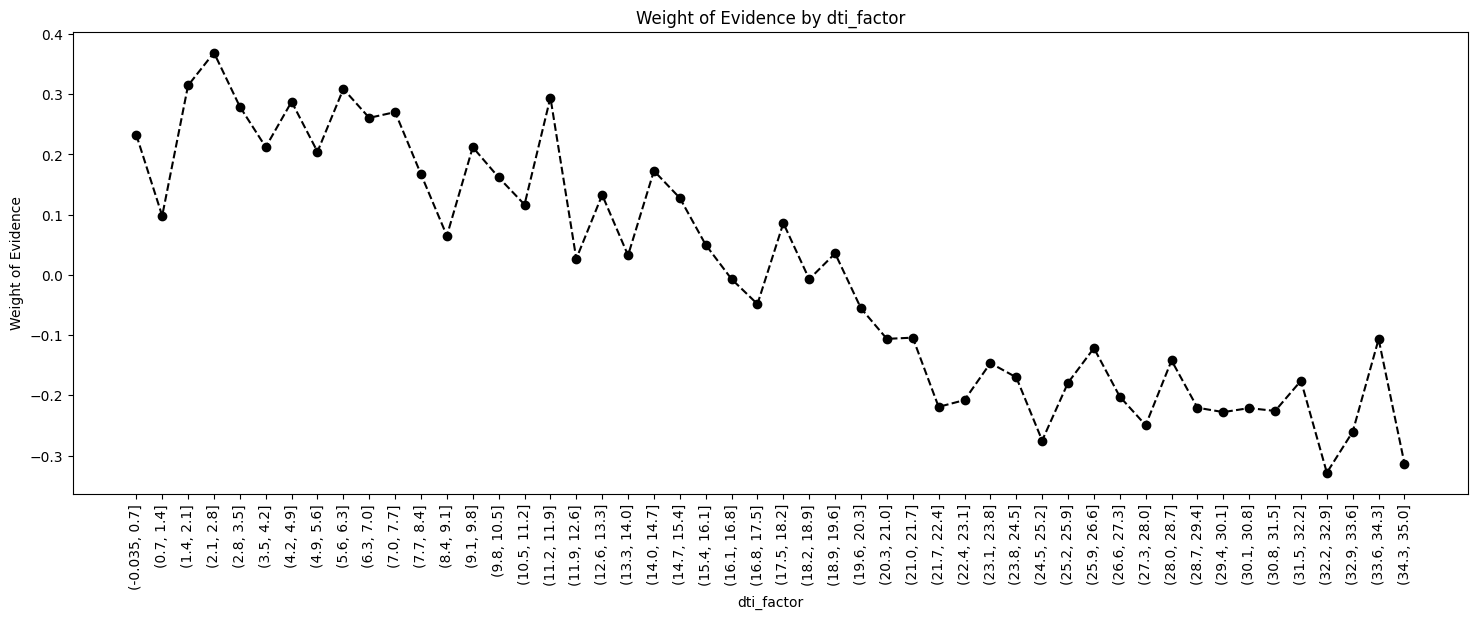

In [453]:
plot_by_woe(df_temp, 90)

In [454]:
df_inputs_prepr['dti:<=1.4'] = np.where((df_inputs_prepr['dti'] <= 1.4), 1, 0)
df_inputs_prepr['dti:1.4-3.5'] = np.where((df_inputs_prepr['dti'] > 1.4) & (df_inputs_prepr['dti'] <= 3.5), 1, 0)
df_inputs_prepr['dti:3.5-7.7'] = np.where((df_inputs_prepr['dti'] > 3.5) & (df_inputs_prepr['dti'] <= 7.7), 1, 0)
df_inputs_prepr['dti:7.7-10.5'] = np.where((df_inputs_prepr['dti'] > 7.7) & (df_inputs_prepr['dti'] <= 10.5), 1, 0)
df_inputs_prepr['dti:10.5-16.1'] = np.where((df_inputs_prepr['dti'] > 10.5) & (df_inputs_prepr['dti'] <= 16.1), 1, 0)
df_inputs_prepr['dti:16.1-20.3'] = np.where((df_inputs_prepr['dti'] > 16.1) & (df_inputs_prepr['dti'] <= 20.3), 1, 0)
df_inputs_prepr['dti:20.3-21.7'] = np.where((df_inputs_prepr['dti'] > 20.3) & (df_inputs_prepr['dti'] <= 21.7), 1, 0)
df_inputs_prepr['dti:21.7-22.4'] = np.where((df_inputs_prepr['dti'] > 21.7) & (df_inputs_prepr['dti'] <= 22.4), 1, 0)
df_inputs_prepr['dti:22.4-35'] = np.where((df_inputs_prepr['dti'] > 22.4) & (df_inputs_prepr['dti'] <= 35), 1, 0)
df_inputs_prepr['dti:>35'] = np.where((df_inputs_prepr['dti'] > 35), 1, 0)

In [455]:
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_record'])]
df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_record_factor', df_targets_prepr[df_inputs_prepr_temp.index])
df_temp

C:\Users\User\AppData\Local\Temp\ipykernel_4628\770603847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)


mths_since_last_record_factor  n_obs  prop_good  prop_n_obs  n_good  n_bad  \
0                 (-0.119, 2.38]    265   0.750943    0.020967   199.0   66.0   
1                   (2.38, 4.76]     19   0.894737    0.001503    17.0    2.0   
2                   (4.76, 7.14]     48   0.916667    0.003798    44.0    4.0   
3                   (7.14, 9.52]     40   0.900000    0.003165    36.0    4.0   
4                   (9.52, 11.9]     45   0.933333    0.003560    42.0    3.0   
5                  (11.9, 14.28]     89   0.932584    0.007042    83.0    6.0   
6                 (14.28, 16.66]     60   0.933333    0.004747    56.0    4.0   
7                 (16.66, 19.04]     91   0.967033    0.007200    88.0    3.0   
8                 (19.04, 21.42]     84   0.940476    0.006646    79.0    5.0   
9                  (21.42, 23.8]     71   0.887324    0.005618    63.0    8.0   
10                 (23.8, 26.18]    102   0.911765    0.008070    93.0    9.0   
11                (26.18, 28.56]    107   0.869159    0.008466    93.0   14.0   
12                (28.56, 30.94]    108   0.907407    0.008545    98.0   10.0   
13                (30.94, 33.32]    167   0.880240    0.013213   147.0   20.0   
14                 (33.32, 35.7]    120   0.908333    0.009494   109.0   11.0   
15                 (35.7, 38.08]    257   0.949416    0.020334   244.0   13.0   
16                (38.08, 40.46]    161   0.962733    0.012738   155.0    6.0   
17                (40.46, 42.84]    202   0.920792    0.015982   186.0   16.0   
18                (42.84, 45.22]    303   0.910891    0.023973   276.0   27.0   
19                 (45.22, 47.6]    205   0.912195    0.016220   187.0   18.0   
20                 (47.6, 49.98]    208   0.937500    0.016457   195.0   13.0   
21                (49.98, 52.36]    401   0.917706    0.031727   368.0   33.0   
22                (52.36, 54.74]    252   0.916667    0.019938   231.0   21.0   
23                (54.74, 57.12]    408   0.906863    0.032281   370.0   38.0   
24                 (57.12, 59.5]    299   0.916388    0.023657   274.0   25.0   
25                 (59.5, 61.88]    309   0.893204    0.024448   276.0   33.0   
26                (61.88, 64.26]    389   0.933162    0.030778   363.0   26.0   
27                (64.26, 66.64]    265   0.913208    0.020967   242.0   23.0   
28                (66.64, 69.02]    402   0.895522    0.031806   360.0   42.0   
29                 (69.02, 71.4]    259   0.915058    0.020492   237.0   22.0   
30                 (71.4, 73.78]    230   0.913043    0.018198   210.0   20.0   
31                (73.78, 76.16]    366   0.893443    0.028958   327.0   39.0   
32                (76.16, 78.54]    254   0.917323    0.020097   233.0   21.0   
33                (78.54, 80.92]    228   0.894737    0.018039   204.0   24.0   
34                 (80.92, 83.3]    334   0.877246    0.026426   293.0   41.0   
35                 (83.3, 85.68]    183   0.863388    0.014479   158.0   25.0   
36                (85.68, 88.06]    338   0.840237    0.026743   284.0   54.0   
37                (88.06, 90.44]    213   0.863850    0.016853   184.0   29.0   
38                (90.44, 92.82]    221   0.819005    0.017486   181.0   40.0   
39                 (92.82, 95.2]    407   0.820639    0.032202   334.0   73.0   
40                 (95.2, 97.58]    293   0.866894    0.023182   254.0   39.0   
41                (97.58, 99.96]    330   0.896970    0.026110   296.0   34.0   
42               (99.96, 102.34]    487   0.864476    0.038532   421.0   66.0   
43              (102.34, 104.72]    370   0.897297    0.029274   332.0   38.0   
44               (104.72, 107.1]    582   0.896907    0.046048   522.0   60.0   
45               (107.1, 109.48]    392   0.885204    0.031015   347.0   45.0   
46              (109.48, 111.86]    374   0.868984    0.029591   325.0   49.0   
47              (111.86, 114.24]    562   0.884342    0.044466   497.0   65.0   
48              (114.24, 116.62]  

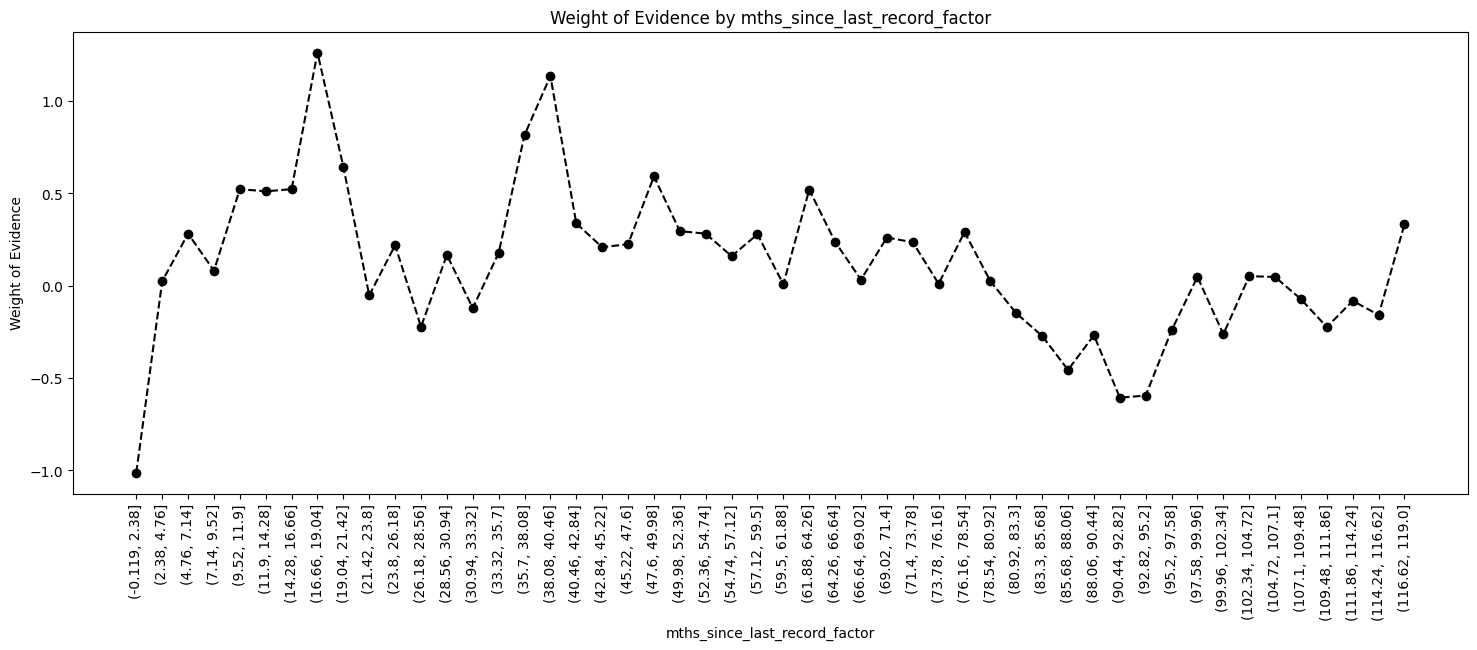

In [456]:
plot_by_woe(df_temp, 90)

In [457]:
df_inputs_prepr['mths_since_last_record:Missing'] = np.where((df_inputs_prepr['mths_since_last_record'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_record:0-2'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 0) & (df_inputs_prepr['mths_since_last_record'] <= 2), 1, 0)
df_inputs_prepr['mths_since_last_record:3-20'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 3) & (df_inputs_prepr['mths_since_last_record'] <= 20), 1, 0)
df_inputs_prepr['mths_since_last_record:21-31'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 21) & (df_inputs_prepr['mths_since_last_record'] <= 31), 1, 0)
df_inputs_prepr['mths_since_last_record:32-80'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 32) & (df_inputs_prepr['mths_since_last_record'] <= 80), 1, 0)
df_inputs_prepr['mths_since_last_record:81-86'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 81) & (df_inputs_prepr['mths_since_last_record'] <= 86), 1, 0)
df_inputs_prepr['mths_since_last_record:>=86'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 86), 1, 0)

## Preprocessing the test dataset

### Run the below then go to cell below Data preparation far above
### Set df_inputs_prepr = loan_data_inputs_test
### Set df_targets_prepr = loan_data_inputs_test
### Then re-run all cells

In [458]:
#loan_data_inputs_train = df_inputs_prepr
#loan_data_inputs_test = df_inputs_prepr

In [459]:
loan_data_inputs_train.shape

(373028, 322)

In [460]:
loan_data_inputs_test.shape

(93257, 322)

In [462]:
loan_data_inputs_train.to_csv(r'D:\Datasets\LendingClub\loan_data_inputs_train.csv')
loan_data_targets_train.to_csv(r'D:\Datasets\LendingClub\loan_data_targets_train.csv')
loan_data_inputs_test.to_csv(r'D:\Datasets\LendingClub\loan_data_inputs_test.csv')
loan_data_targets_test.to_csv(r'D:\Datasets\LendingClub\loan_data_targets_test.csv')